**Nosson Weissman**

**DAV 6150 - Data Science**

**Professor James Topor**

**Summer 2022**

__DAV 6150 Module 11 : Random Forest vs Decision Tree__

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
import os
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, confusion_matrix

# Introduction

In this project we are given a data set pertaining to the educational outcomes of New York State high school students as of the end of the 2018/19 academic year. Included in the data set are counts for enrollment and graduation by district and cohort, and subgrouped data on student demographics. 

The data is given in aggregate form and as such is analyzed as an aggregation (as opposed to on an individual student level).

We will attempt to compare decision tree algorithm/s vs random forest.

In order to get there, we will go through the following steps:
- Inspect and clean data
- Perfom an exploratory data analysis
- Transform data as needed
- Construct regression methods on processed data
- Evaluate and select models

We then will use information gained in the above steps to determine which variables we can reliably utilize and which types of models work best for this task.

## Load Data Set

We begin by loading the data from github into pandas and conducting a preliminary inspection. We know that the '-' character is used as a missing value representation in this data set, so we have pandas replace them with proper NaN entries.

In [40]:
filepath = 'https://raw.githubusercontent.com/codepharmer/AI-6150/main/M11%20Random%20Forest%20vs%20Descision%20Tree/M11_Data.csv'
raw_data = pd.read_csv(filepath, na_values = '-')
raw_data

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658.0,464.0,71%,310.0,47%,148.0,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324.0,246.0,76%,169.0,52%,65.0,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334.0,218.0,65%,141.0,42%,83.0,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367.0,248.0,68%,183.0,50%,91.0,25%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73147,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,18,Not Migrant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73148,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,20,Homeless,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73149,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,21,Not Homeless,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73150,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,23,Not in Foster Care,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We remove the '%' signs and check data types:

In [41]:
raw_data.replace('%', '', regex = True, inplace = True)

percents = set(['grad_pct', 'reg_pct',  'dropout_pct'])
for col_name in percents:
    raw_data[col_name] = pd.to_numeric(raw_data[col_name])

dict(raw_data.dtypes)

{'report_school_year': dtype('O'),
 'aggregation_index': dtype('int64'),
 'aggregation_type': dtype('O'),
 'aggregation_name': dtype('O'),
 'nrc_code': dtype('int64'),
 'nrc_desc': dtype('O'),
 'county_code': dtype('int64'),
 'county_name': dtype('O'),
 'nyc_ind': dtype('int64'),
 'membership_desc': dtype('O'),
 'subgroup_code': dtype('int64'),
 'subgroup_name': dtype('O'),
 'enroll_cnt': dtype('float64'),
 'grad_cnt': dtype('float64'),
 'grad_pct': dtype('float64'),
 'reg_cnt': dtype('float64'),
 'reg_pct': dtype('float64'),
 'dropout_cnt': dtype('float64'),
 'dropout_pct': dtype('float64')}

We remove extraneous metadata columns, since the whole data set is for the 2018/19 school year and district-level aggregations only:

In [42]:
raw_data['report_school_year'].unique()

array(['2018-19'], dtype=object)

In [43]:
raw_data['aggregation_index'].unique()

array([3], dtype=int64)

In [44]:
raw_data['aggregation_type'].unique()

array(['District'], dtype=object)

In [45]:
raw_data.drop(['report_school_year', 'aggregation_index', 'aggregation_type'], axis = 1, inplace = True)

raw_data.shape

(73152, 16)

Superficial check for missing values:

In [46]:
dict(raw_data.isna().sum())

{'aggregation_name': 0,
 'nrc_code': 0,
 'nrc_desc': 0,
 'county_code': 0,
 'county_name': 0,
 'nyc_ind': 0,
 'membership_desc': 0,
 'subgroup_code': 0,
 'subgroup_name': 0,
 'enroll_cnt': 33478,
 'grad_cnt': 33478,
 'grad_pct': 33478,
 'reg_cnt': 33478,
 'reg_pct': 33478,
 'dropout_cnt': 33478,
 'dropout_pct': 33478}

This 'missing' data appears to be more of a case of subsetting idiosyncrasy where entire subgroups lack numeric data, rather than scattered single-point gaps in otherwise complete rows.

**Analysis of subgroups:**

In [47]:
raw_data['subgroup_name'].unique()

array(['All Students', 'Female', 'Male', 'American Indian/Alaska Native',
       'Black', 'Hispanic', 'Asian/Pacific Islander', 'White',
       'Multiracial', 'General Education Students',
       'Students with Disabilities', 'Not English Language Learner',
       'English Language Learner', 'Formerly English Language Learner',
       'Economically Disadvantaged', 'Not Economically Disadvantaged',
       'Migrant', 'Not Migrant', 'Homeless', 'Not Homeless',
       'Not in Foster Care', 'Parent Not in Armed Forces',
       'In Foster Care', 'Parent in Armed Forces'], dtype=object)

In [48]:
raw_data['subgroup_name'].isna().sum()

0

We split the data set into mutually exclusive groupings and take a glance at their contents:

In [49]:
def districts_entries_missing(label, filter_terms):
    raw_data_dem = raw_data[raw_data['subgroup_name'].isin(filter_terms)].copy()
    print('Districts in '+label+' aggregation:' + str(raw_data_dem.aggregation_name.nunique()) + '\n')
    print('Entries for '+label+' aggregation: ' + str(raw_data_dem.shape[0]) + '\n')
    print('Missing data entries: ' + str(raw_data_dem.enroll_cnt.isna().sum()) + '\n\n---- \n')

In [50]:
districts_entries_missing('complete', ['All Students'])

districts_entries_missing('gender', ['Female', 'Male'])

race = ['American Indian/Alaska Native', 'Black', 'Hispanic', 'Asian/Pacific Islander', 'White', 'Multiracial']
districts_entries_missing('race', race)

disability = ['General Education Students', 'Students with Disabilities']
districts_entries_missing('disability', disability)

ell = ['Not English Language Learner', 'English Language Learner', 'Formerly English Language Learner']
districts_entries_missing('English language learner', ell)

economic = ['Economically Disadvantaged', 'Not Economically Disadvantaged']
districts_entries_missing('economically advantaged', economic)

districts_entries_missing('migrant', ['Migrant', 'Not Migrant'])

districts_entries_missing('homeslessness', ['Homeless', 'Not Homeless'])

foster = ['Not in Foster Care', 'In Foster Care']
districts_entries_missing('in foster care or not', foster)

armedforces = ['Parent Not in Armed Forces', 'Parent in Armed Forces']
districts_entries_missing('armed forces', armedforces)


Districts in complete aggregation:680

Entries for complete aggregation: 4074

Missing data entries: 28

---- 

Districts in gender aggregation:680

Entries for gender aggregation: 8128

Missing data entries: 188

---- 

Districts in race aggregation:680

Entries for race aggregation: 17222

Missing data entries: 9038

---- 

Districts in disability aggregation:680

Entries for disability aggregation: 8084

Missing data entries: 820

---- 

Districts in English language learner aggregation:680

Entries for English language learner aggregation: 7356

Missing data entries: 5040

---- 

Districts in economically advantaged aggregation:680

Entries for economically advantaged aggregation: 8074

Missing data entries: 238

---- 

Districts in migrant aggregation:680

Entries for migrant aggregation: 4436

Missing data entries: 4400

---- 

Districts in homeslessness aggregation:680

Entries for homeslessness aggregation: 6776

Missing data entries: 4852

---- 

Districts in in foster care or

In [51]:
raw_data['membership_desc'].unique()

array(['2013 Total Cohort - 6 Year Outcome',
       '2014 Total Cohort - 5 Year Outcome',
       '2015 Total Cohort - 4 Year Outcome',
       '2014 Total Cohort - 5 Year Outcome - August 2019',
       '2015 Total Cohort - 4 Year Outcome - August 2019',
       '2013 Total Cohort - 6 Year Outcome - August 2019'], dtype=object)

We note that with 6 cohorts per school district, the total number of entries for 'All Students' should be 4080, and for binary subgroup splits 8160.

Due to the relatively complete data available we will conduct our numeric EDA only on the gender and economic aggregations, simply removing the small numbers of missing entries. We can do this since these are _entire rows_ lacking numeric data and no valid data is being lost in the process.

The 'All Students' aggregation will actually _not_ be used since it is simply less descriptive than the more granular subgroups.

In [58]:
raw_data_all = raw_data[raw_data['subgroup_name'].isin(["All Students"])].copy()
raw_data_all.dropna(inplace = True)

raw_data_all.shape

(4046, 16)

In [56]:
raw_data_gender = raw_data[raw_data['subgroup_name'].isin(["Male", "Female"])].copy()
raw_data_gender.dropna(inplace = True)

raw_data_gender.shape

NameError: name 'raw_data_gender' is not defined

In [33]:
raw_data_economic.dropna(inplace = True)

raw_data_economic.shape

(7836, 26)

# Exploratory Data Analysis

#### Attribute Information:

0. report_school_year: Indicates school year for which high school graduation info is being reported
1. aggregation_index: Numeric code identifying manner in which high school graduation data has been aggregated
2. aggregation_type: Text description of how high school graduation data has been aggregated
3. nrc_code: Numeric code identifying "needs / resource capacity", which is an indicator of the type of school district
4. nrc_desc: Text description of the type of school district
5. county_code: Numeric code for county name
6. county_name: Full name of applicable NY State county
7. nyc_ind: Indicates whether or not the school district resides within the borders of NYC
8. membership_desc: Indicates school year in which students first enrolled in High School
9. subgroup_code: Numeric code identifying student subgrouping
10. subgroup_name: Text description of student subgrouping; a student may belong to more than one subgrouping
11. enroll_cnt: How many students of the indicated subgrouping were enrolled during the given school year
12. grad_cnt: How many enrolled students of the indicated subgrouping graduated at the end of the given school year
13. grad_pct: What percentage of enrolled students of the indicated subgrouping graduated at the end for the given school year
14. local_cnt: How many enrolled students of the indicated subgrouping were awarded a "Local" diploma
15. local_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Local" diploma
16. reg_cnt: How many enrolled students of the indicated subgrouping were awarded a "Regents" diploma
17. reg_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Regents" diploma
18. reg_adv_cnt: How many enrolled students of the indicated subgrouping were awarded a "Regents Advanced" diploma
19. reg_adv_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Regents Advanced" diploma
20. non_diploma_credential_cnt: How many enrolled students of the indicated subgrouping achieved a non-diploma credential
21. non_diploma_credential_pct: What percentage of enrolled students of the indicated subgrouping achieved a non-diploma credential
22. still_enr_cnt: How many enrolled students of the indicated subgrouping did not graduate but were still enrolled
23. still_enr_pct: What percentage of enrolled students of the indicated subgrouping did not graduate but were still enrolled
24. ged_cnt: How many enrolled students of the indicated subgrouping were awarded a "GED" diploma
25. ged_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "GED" diploma
26. dropout_cnt: How many enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year
27. dropout_pct: What percentage of enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year



#### Types of Variables:
<pre>
0 - 2. Non-predictive metadata attributes.
3 - 4. Categorical attribute for needs/resource capacity.
5 - 6. Categorical attribute for county.
7. Indicator (boolean) categorical attribute for district in / out of NYC.
8. Categorical attribute for cohort, when student was first enrolled.
9 - 10. Subgroupings. When split into exclusive subsets, this becomes a categorical attribute for gender, race, etc.
11. Numeric non-negative integer for enrollment headcount in a particular cohort for a particular school district.
12 - 13. Numeric non-negative integer for graduated student headcount and approximated percentage of total enrollment.
14 - 19. Numeric non-negative integers for graduating diploma types, plus approximated percentages.
20 - 21. Numeric non-negative integers for non-graduated credential student headcount and approx percentage.
22 - 23. Numeric non-negative integers for non-graduated still-enrolled student headcount and approx percentage.
24 - 25. Numeric non-negative integers for non-graduated 'GED' diploma student headcount and approx percentage.
26 - 27. Numeric non-negative integers for non-graduated dropout student headcount and approx percentage.
</pre>

In [34]:
numerics = ['enroll_cnt', 'grad_cnt', 'grad_pct', 'local_cnt', 
            'local_pct', 'reg_cnt', 'reg_pct', 'reg_adv_cnt', 'reg_adv_pct',
            'non_diploma_credential_cnt', 'non_diploma_credential_pct',
            'still_enr_cnt', 'still_enr_pct', 'ged_cnt', 'ged_pct', 'dropout_cnt', 'dropout_pct']

Helper functions for EDA:

In [35]:
def eda_plot(df, col):
    '''Generate histogram and box plot for a given numeric attribute.'''
    plt.figure(figsize = (10,4))
    
    plt.subplot(1,2,1)
    plt.title('Histogram of ' + col.strip())
    sns.histplot(x = df[col], kde = True, binwidth = df[col].std()/10)
    plt.subplot(1,2,2)
    plt.title('Box Plot of ' + col.strip())
    sns.boxenplot(x = df[col])
    
    plt.tight_layout()
    plt.show()

def eda_cat_plot(df, col, rotate = 0, flip = False):
    '''Generate count plot for a given categorical attribute.'''
    plt.figure(figsize = (6,4))
    
    plt.title('Count of ' + col.strip())
    if flip:
        sns.countplot(y = col, data = df)
    else:
        plt.xticks(rotation = rotate)
        sns.countplot(x = col, data = df)
    
    plt.tight_layout()
    plt.show()

def eda_modify(df_old, df_new, col):
    '''Compare before-and-after histograms and box plots for a modified numeric attribute.'''
    plt.figure(figsize = (6,4))
    
    plt.subplot(2,2,1)
    plt.title('Old: ' + col)
    sns.histplot(x = df_old[col], kde = True)
    plt.subplot(2,2,2)
    sns.boxenplot(x = df_old[col])
    
    plt.subplot(2,2,3)
    plt.title('New: ' + col)
    sns.histplot(x = df_new[col], kde = True)
    plt.subplot(2,2,4)
    sns.boxenplot(x = df_new[col])
    
    plt.tight_layout()
    plt.show()

def cut_outliers(dropset, df, varb, threshold = 5, left_tail = False):
    '''Function to conduct EDA with outliers past a certain standard deviation threshold omitted.'''
    
    if left_tail:
        outliers = df[df[varb] < df[varb].mean() - threshold*df[varb].std()].index
    else:
        outliers = df[df[varb] > df[varb].mean() + threshold*df[varb].std()].index
    
    eda_plot(df.drop(outliers, axis = 0), varb)
    for o in outliers:
        dropset.add(o)

    print(str(len(outliers)) + ' outliers omitted.')
    return dropset

## Numeric Variables

### Breakdown of Numeric Variables

The numeric variables in this data set have several direct relationships to one another.

Enrollment count (enroll_cnt) is the total headcount of students enrolled in a particular cohort and subgroup for a particular school district. It is a non-negative integer.

Graduating count (grad_cnt) is the total headcount _within_ that number who have graduated as of the end of the 2018-19 school year. As such it is a non-negative integer bounded above by the value of enroll_cnt in the same row.

local_cnt, reg_cnt, and reg_adv_cnt are headcounts of specific types of graduated students based on the type of diploma awarded. In most given rows, these non-negative integers sum up to the value of grad_cnt within that row.

non_diploma_credential_cnt, still_enr_cnt, ged_cnt and dropout_cnt are headcounts of students associated with various non-graduation outcomes. These four numbers summed with grad_cnt in most given rows equal enroll_cnt.

Furthermore, there exist percentage attributes which are each just measures of a headcount attribute divided by enroll_cnt, multiplied by 100 and then rounded to an integer. These attributes are bounded between 0 and 100.

There is a bit of noise in the data set with small numbers of students sometimes left unaccounted for. However in general we can expect an attribute created by just multiplying dropout_pct with enroll_cnt to come close to modeling dropout_cnt, albeit in an uninteresting sense.

In [36]:
balance_all = np.array(raw_data_all['grad_cnt']) + np.array(raw_data_all['non_diploma_credential_cnt']) + np.array(raw_data_all['still_enr_cnt']) + np.array(raw_data_all['ged_cnt']) + np.array(raw_data_all['dropout_cnt']) - np.array(raw_data_all['enroll_cnt'])

print('All students data:')
print('% Entries with students unaccounted for: ' + str(round(100*np.count_nonzero(balance_all) / len(balance_all), 2)) + '%')
print('Students unaccounted for: ' + str(int(-1*balance_all.sum())) + '\n')

balance_gender = np.array(raw_data_gender['grad_cnt']) + np.array(raw_data_gender['non_diploma_credential_cnt']) + np.array(raw_data_gender['still_enr_cnt']) + np.array(raw_data_gender['ged_cnt']) + np.array(raw_data_gender['dropout_cnt']) - np.array(raw_data_gender['enroll_cnt'])

print('Gender-subgrouped data:')
print('% Entries with students unaccounted for: ' + str(round(100*np.count_nonzero(balance_gender) / len(balance_gender), 2)) + '%')
print('Students unaccounted for: ' + str(int(-1*balance_gender.sum())) + '\n')

balance_economic = np.array(raw_data_economic['grad_cnt']) + np.array(raw_data_economic['non_diploma_credential_cnt']) + np.array(raw_data_economic['still_enr_cnt']) + np.array(raw_data_economic['ged_cnt']) + np.array(raw_data_economic['dropout_cnt']) - np.array(raw_data_economic['enroll_cnt'])

print('Economic-subgrouped data:')
print('% Entries with students unaccounted for: ' + str(round(100*np.count_nonzero(balance_economic) / len(balance_economic), 2)) + '%')
print('Students unaccounted for: ' + str(int(-1*balance_economic.sum())) + '\n')

All students data:
% Entries with students unaccounted for: 11.32%
Students unaccounted for: 690

Gender-subgrouped data:
% Entries with students unaccounted for: 6.3%
Students unaccounted for: 684

Economic-subgrouped data:
% Entries with students unaccounted for: 6.41%
Students unaccounted for: 676



In [37]:
print('Total number of students: ' + str(int(raw_data_all['enroll_cnt'].sum())))

Total number of students: 1218026


We see that almost 700 out of 1.2 million students are not accounted for, so the level of noise is actually quite low.

#### Overview Statistics

In [38]:
raw_data_gender[numerics].describe()

,enroll_cnt,grad_cnt,grad_pct,local_cnt,local_pct,reg_cnt,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct
count,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000,7940.000000
mean,153.315617,129.932746,88.291436,9.611965,6.260453,68.329345,43.789798,51.991436,38.270655,1.546851,1.266499,8.443955,3.764484,1.056045,0.529219,12.249874,6.093073
std,309.489195,249.606757,11.164616,22.869299,5.931840,155.895410,15.842118,89.316889,19.930416,5.077403,2.191318,30.764922,7.601798,3.729621,1.792281,37.646465,6.167052
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,29.000000,84.000000,1.000000,3.000000,14.000000,34.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,65.000000,58.000000,91.000000,3.000000,5.000000,26.000000,43.000000,22.000000,38.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,5.000000
75%,150.000000,138.000000,95.000000,8.000000,9.000000,57.000000,52.000000,63.000000,52.000000,2.000000,2.000000,4.000000,5.000000,0.000000,0.000000,7.000000,9.000000
max,4959.000000,4293.000000,100.000000,280.000000,100.000000,2718.000000,100.000000,1295.000000,95.000000,221.000000,25.000000,758.000000,100.000000,52.000000,67.000000,621.000000,56.000000


In [39]:
raw_data_economic[numerics].describe()

,enroll_cnt,grad_cnt,grad_pct,local_cnt,local_pct,reg_cnt,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct
count,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000,7836.000000
mean,154.458397,130.803471,87.208652,9.667943,6.738004,68.629403,45.149311,52.506126,35.363961,1.566616,1.428790,8.531266,4.013017,1.065212,0.544410,12.405564,6.721542
std,344.747579,278.876593,11.528560,26.881773,5.796101,175.009798,15.171537,103.306969,20.461853,5.201421,2.580553,34.398738,7.438209,4.016235,1.524928,41.284922,7.134145
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,24.000000,82.000000,1.000000,3.000000,12.000000,35.000000,7.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,57.000000,49.500000,90.000000,3.000000,6.000000,25.000000,45.000000,17.000000,33.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,5.000000
75%,139.000000,122.000000,95.000000,7.000000,10.000000,53.000000,54.000000,47.000000,50.000000,1.000000,2.000000,4.000000,5.000000,0.000000,0.000000,7.000000,10.000000
max,6197.000000,5094.000000,100.000000,467.000000,44.000000,3329.000000,100.000000,1298.000000,94.000000,165.000000,23.000000,1060.000000,100.000000,72.000000,29.000000,719.000000,71.000000


There is significant variation in the size of district-cohorts and likely a right-skew, but besides that there are no obvious anomalies visible in this summary.

### Single-Variable Numeric EDA

**Outlier Removal Policy:** If a count variable has far outlying values, we re-inspect it with the entries that are over 5 standard deviations from the mean omitted. 5 standard deviations is chosen as the threshold to keep the amount of data lost low while still preventing our downstream analyses from being biased towards extraordinarily large district-cohorts. For percentage variables we never remove outliers since these variables are by definition bounded between 0 and 100, so any value within that range is treated as valid.

Note that omitted entries have not actually been removed from the data set for this visualization, but their indices have been added to a drop set so that they may be removed later.

In [40]:
i = 0
dropset_gen = set()
dropset_econ = set()

#### Enroll Count

Gender Subgroup Aggregation:


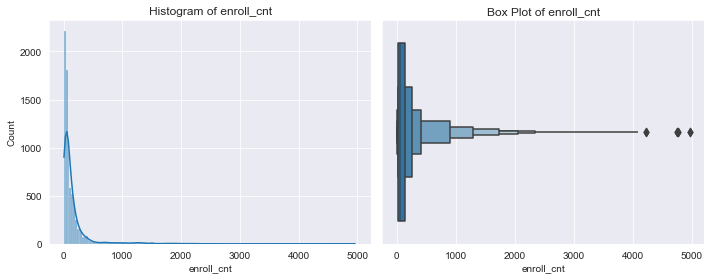

Economic Subgroup Aggregation:


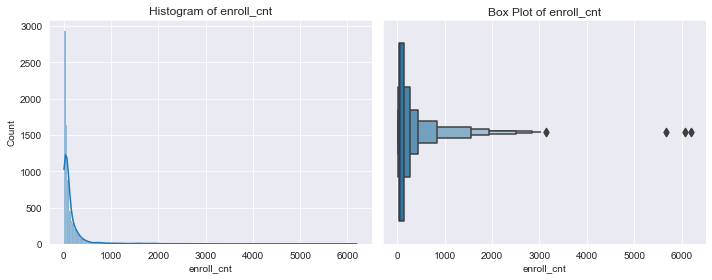

In [41]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


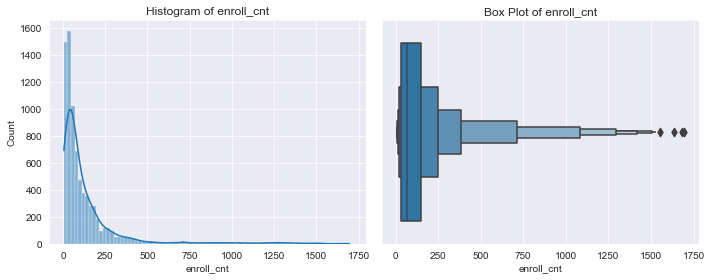

66 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


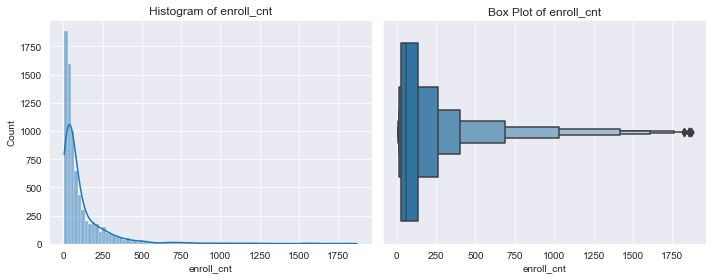

76 outliers omitted.


In [42]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Enroll Count (enroll_cnt) like most of the numeric variables in our data set is a non-negative integer with a right skew. Some extremely large outlying district-cohorts are omitted to get a better view of the distribution which appears to have a kernel density mode of just below 100 students.

#### Graduating Count/Percent

Gender Subgroup Aggregation:


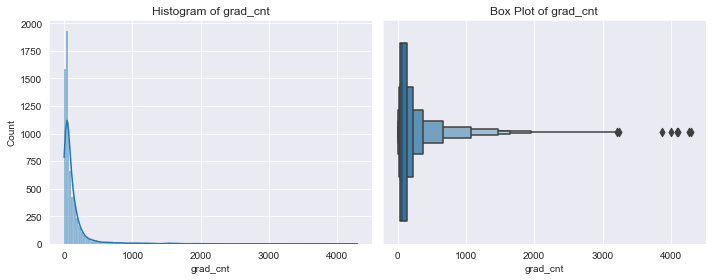

Economic Subgroup Aggregation:


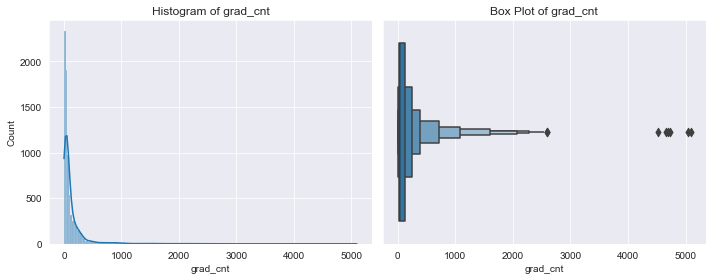

In [43]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


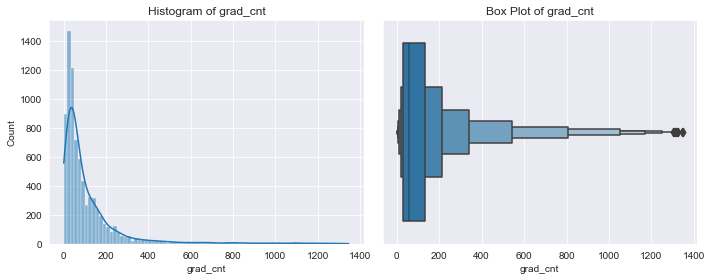

66 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


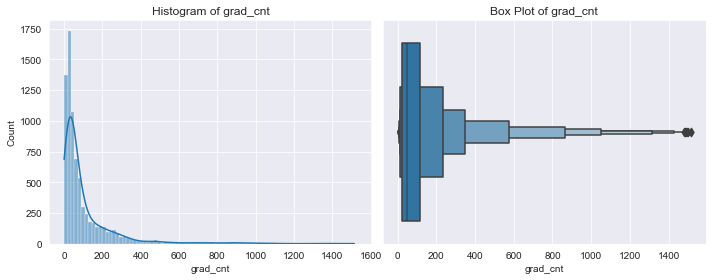

69 outliers omitted.


In [44]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Graduating Count (grad_cnt) has a very similar distribution to enroll_cnt.

Gender Subgroup Aggregation:


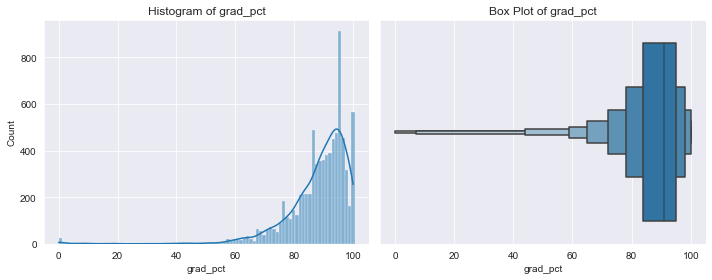

Economic Subgroup Aggregation:


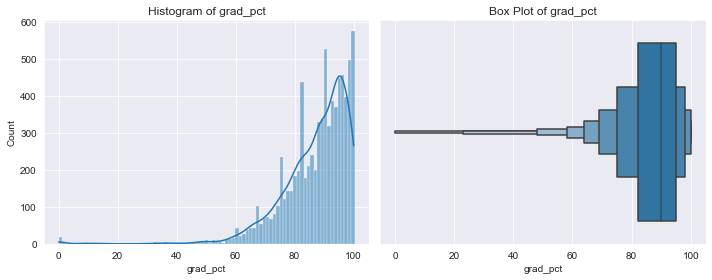

In [45]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Graduating Percentage (grad_pct) has a mode above 90%, so many district-cohorts do enjoy high graduation rates.

#### Local Diploma Count/Percent

Gender Subgroup Aggregation:


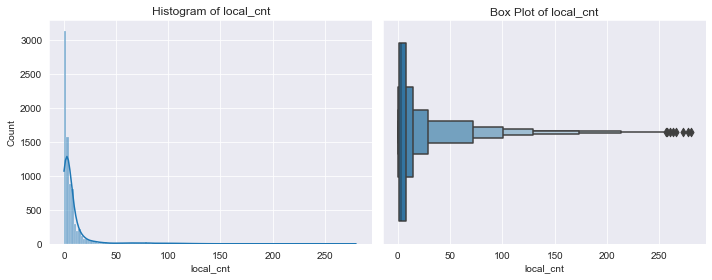

Economic Subgroup Aggregation:


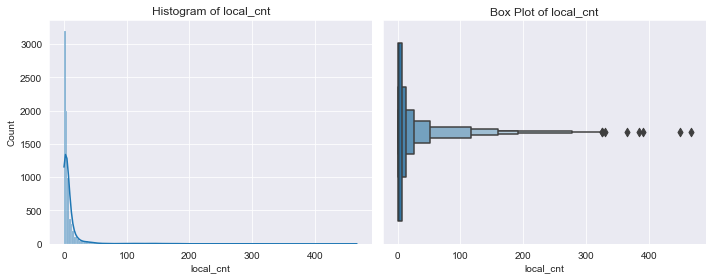

In [46]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


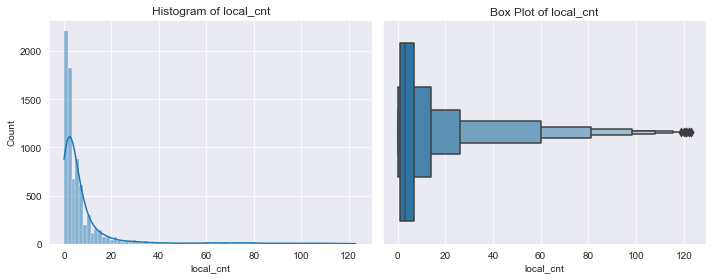

67 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


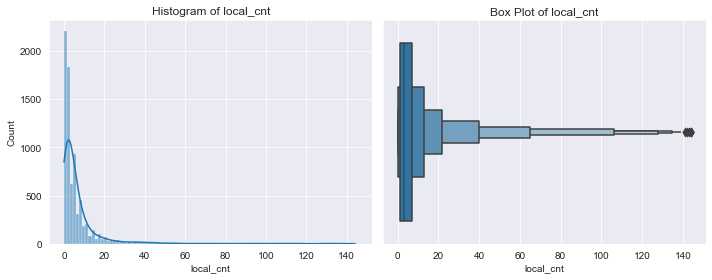

86 outliers omitted.


In [47]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Local Diploma Count (local_cnt) has a similar distribution to enroll_cnt but with a more pronounced skew.

Gender Subgroup Aggregation:


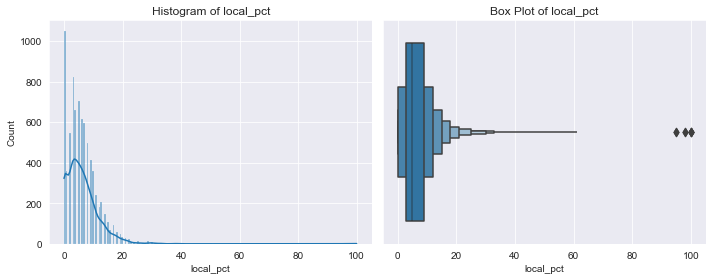

Economic Subgroup Aggregation:


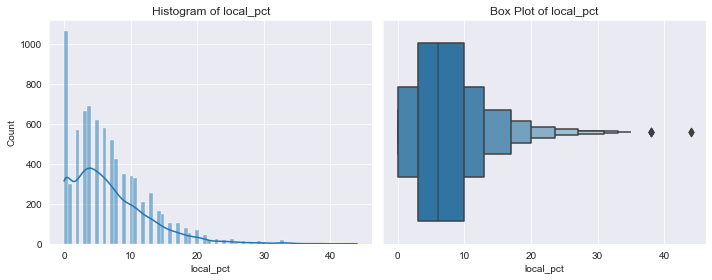

In [48]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Local Diploma Percentage has a noticeably broader distribution in the economically-subgrouped aggregation than in the gender-subgrouped data.

#### Regents Diploma Count/Percent

Gender Subgroup Aggregation:


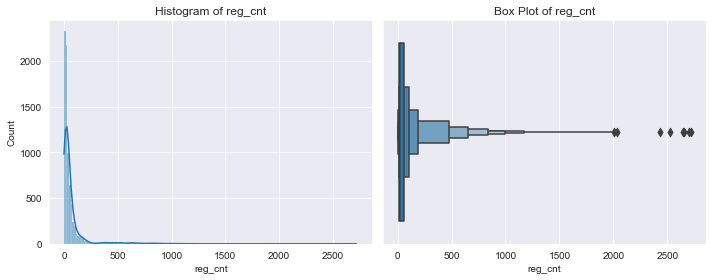

Economic Subgroup Aggregation:


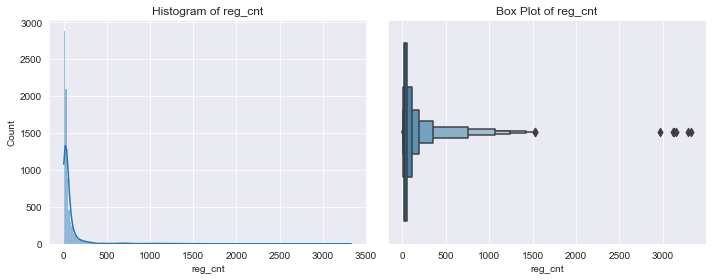

In [49]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


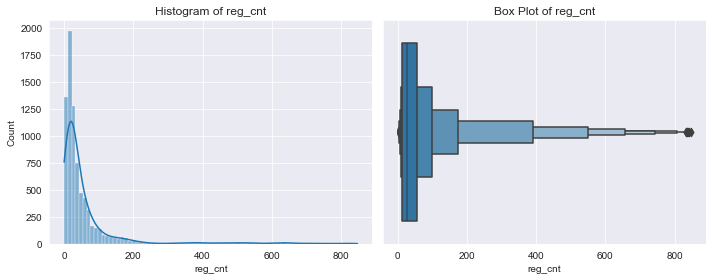

59 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


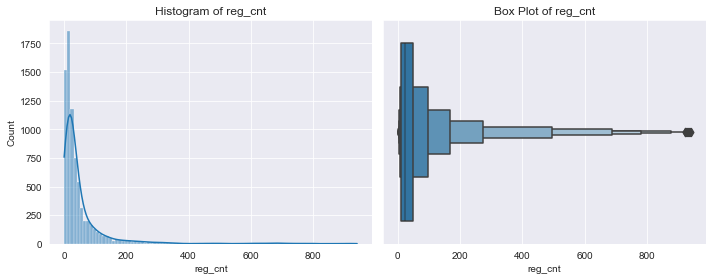

84 outliers omitted.


In [50]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Regents Diploma Count is very similarly distributed to Local Diploma Count.

Gender Subgroup Aggregation:


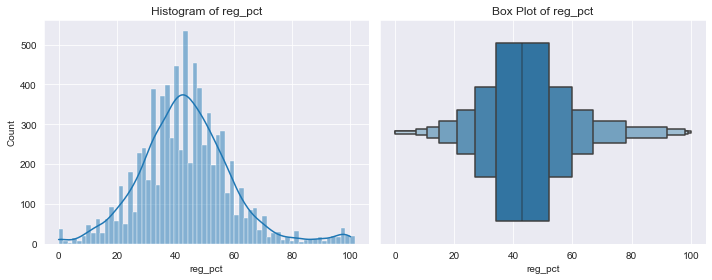

Economic Subgroup Aggregation:


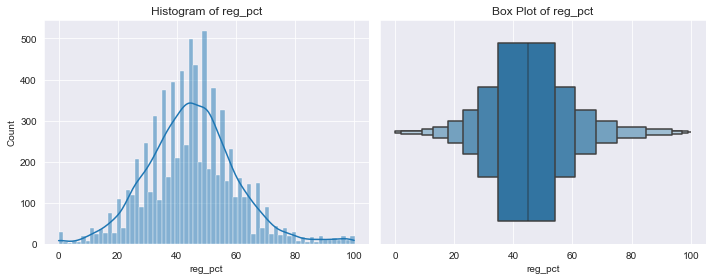

In [51]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Regents Diploma Percentage is the closest to normal distribution, but it still has a very slight right skew, and the percentage data is still represented as discrete integers and not truly continuous numeric data.

#### Regents Advanced Diploma Count/Percent

Gender Subgroup Aggregation:


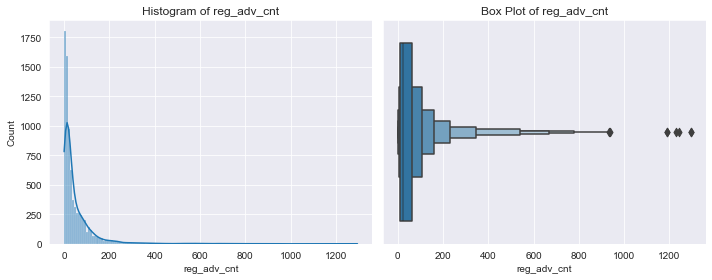

Economic Subgroup Aggregation:


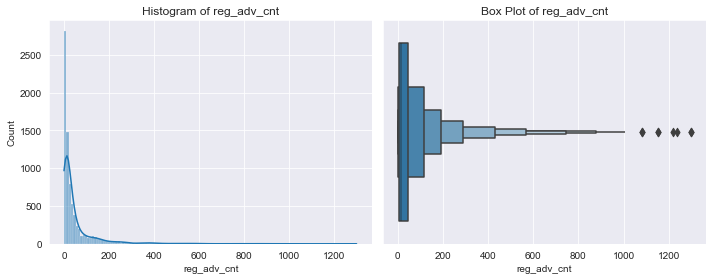

In [52]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


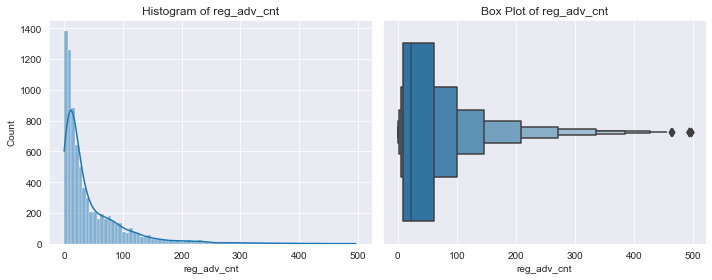

72 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


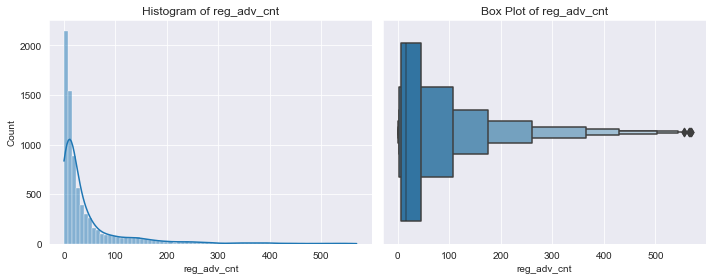

60 outliers omitted.


In [53]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Regents Advanced Diploma Count is another variable similarly distributed to enroll_cnt.

Gender Subgroup Aggregation:


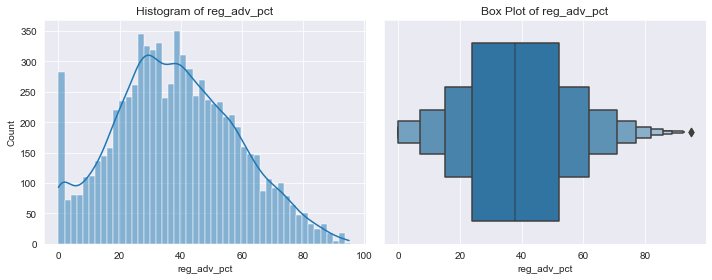

Economic Subgroup Aggregation:


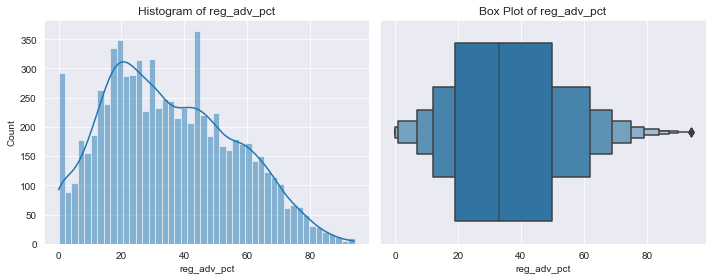

In [54]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Regents Advanced Diploma Percentage has a very broad non-normal distribution in both aggregations.

#### Non-Diploma Credential Count/Percent

Gender Subgroup Aggregation:


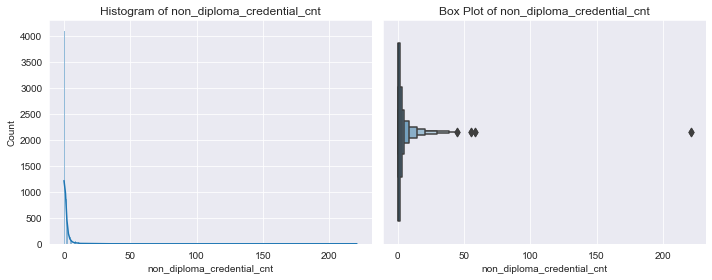

Economic Subgroup Aggregation:


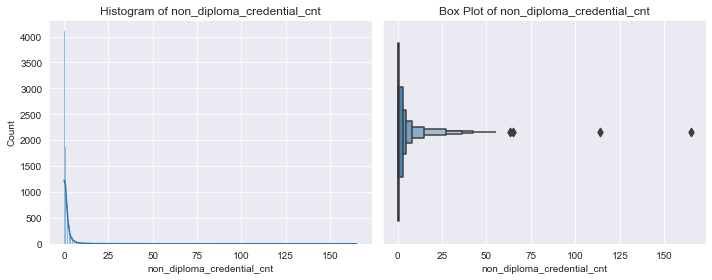

In [55]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


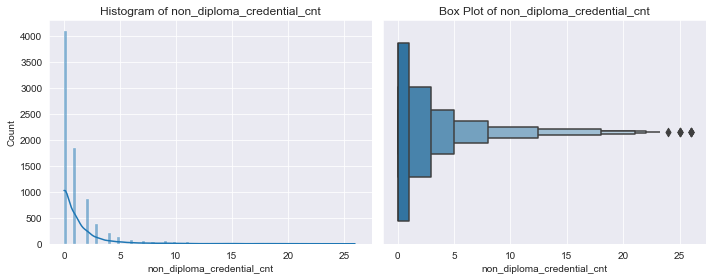

34 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


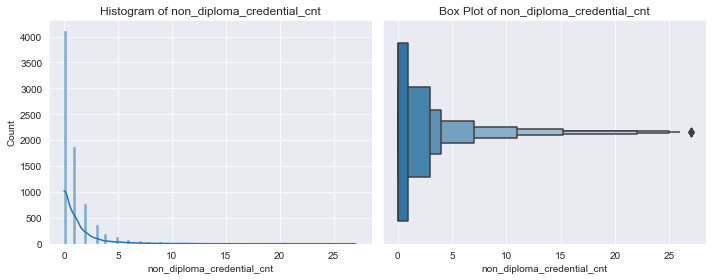

57 outliers omitted.


In [56]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Non-Diploma Counts are low enough that the discrete small integer values are directly visible in the histogram once the outliers have been omitted. In the majority of district-cohorts, this number is 0.

Gender Subgroup Aggregation:


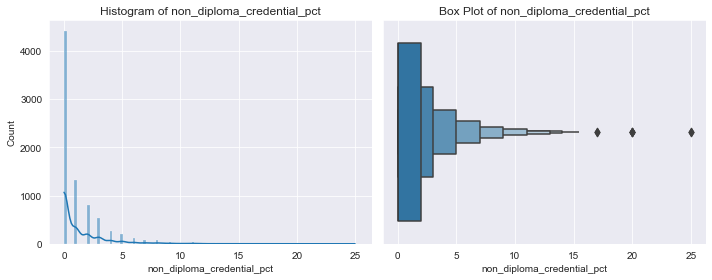

Economic Subgroup Aggregation:


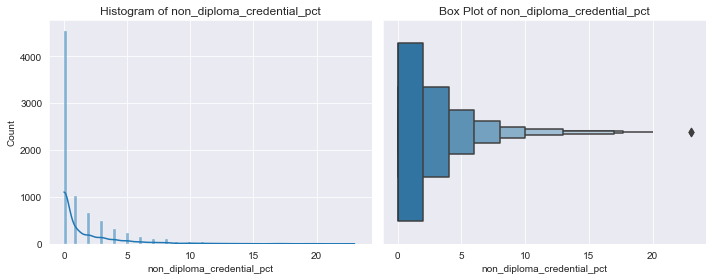

In [57]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Non-Diploma Percentages are also low and visibly discrete due to the integer handling of percentages in this data set.

#### Still Enrolled Count/Percent

Gender Subgroup Aggregation:


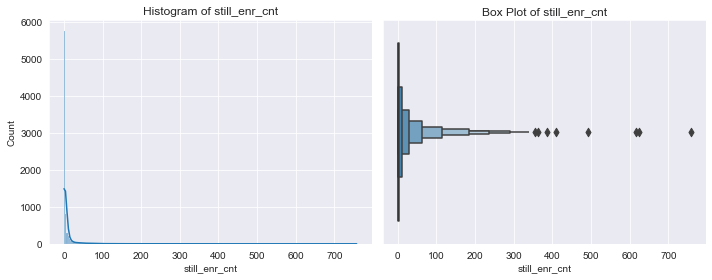

Economic Subgroup Aggregation:


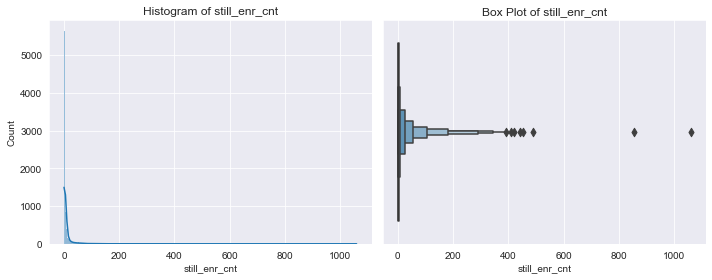

In [58]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


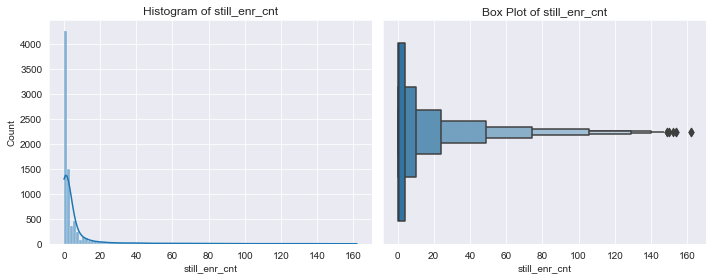

74 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


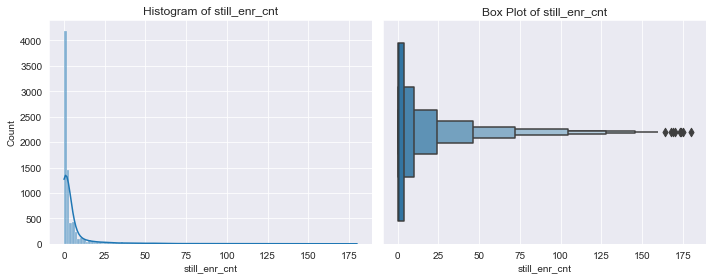

62 outliers omitted.


In [59]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

Still-Enrolled Count has an extreme skew even after outliers have been removed. While the majority is 0, the variation between the non-0 cohorts is vast.

Gender Subgroup Aggregation:


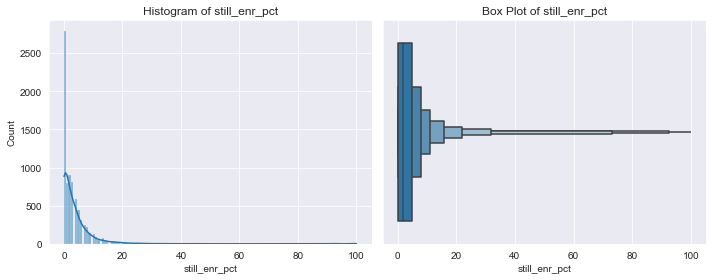

Economic Subgroup Aggregation:


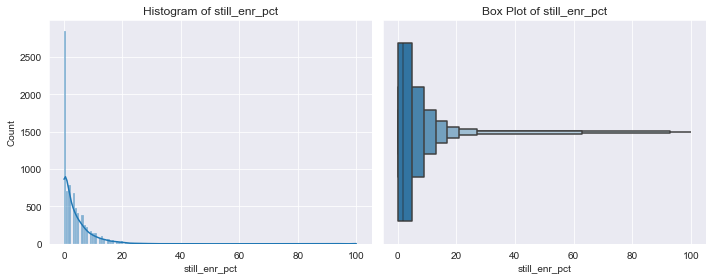

In [60]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Still-Enrolled Percentage has entries extending across its entire range from 0 to 100, even though the majority are at 0.

#### GED Count/Percent

Gender Subgroup Aggregation:


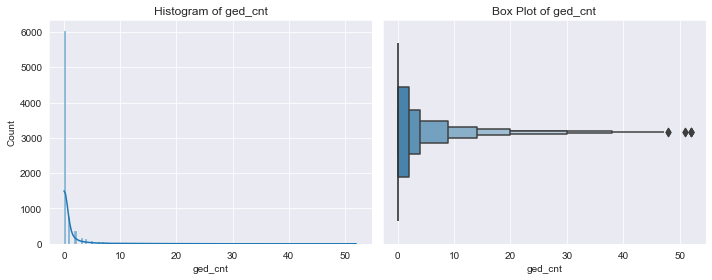

Economic Subgroup Aggregation:


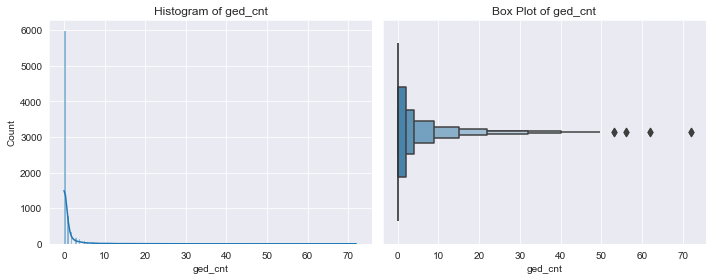

In [61]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


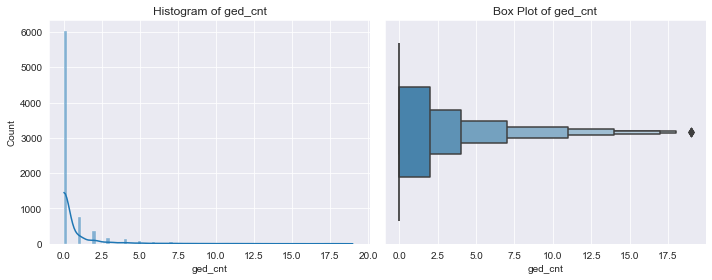

66 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


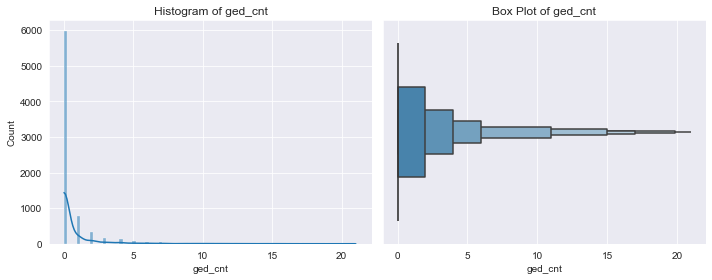

68 outliers omitted.


In [62]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

GED Count is another low-value attribute where discrete integers are visible on the histogram.

Gender Subgroup Aggregation:


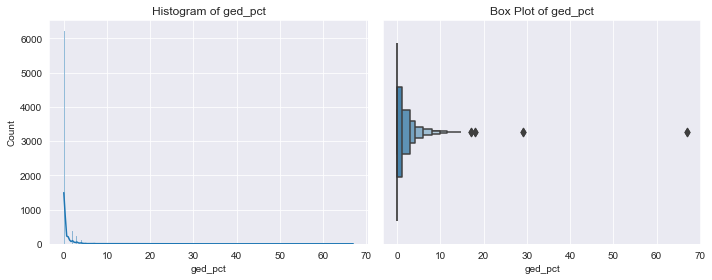

Economic Subgroup Aggregation:


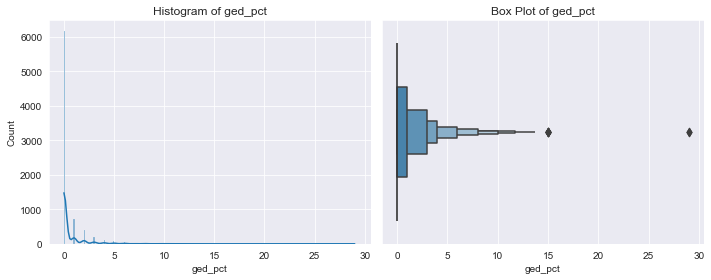

In [63]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

GED Percentage has a few more outlying values in the gender subgrouping than in the economic one.

#### Dropout Count/Percent

Gender Subgroup Aggregation:


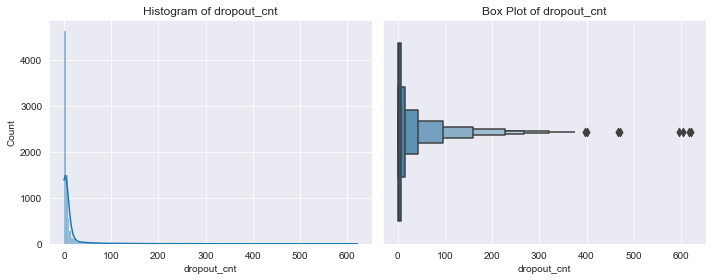

Economic Subgroup Aggregation:


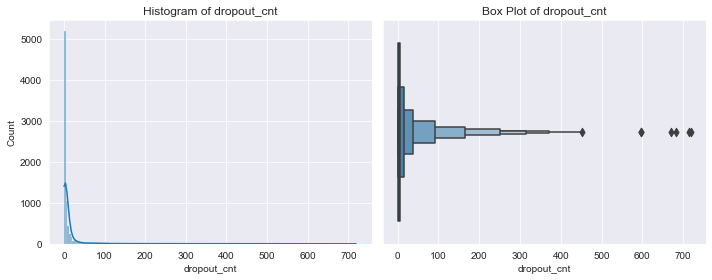

In [64]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Gender Subgroup Aggregation - Outliers Omitted:


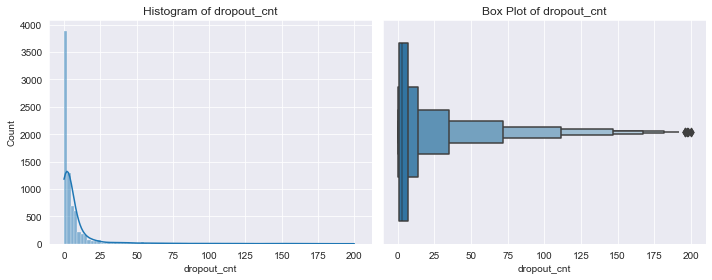

87 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


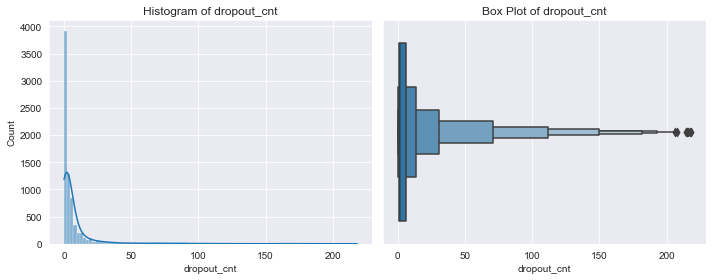

78 outliers omitted.


In [65]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_gen = cut_outliers(dropset_gen, raw_data_gender, numerics[i-1])
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_econ = cut_outliers(dropset_econ, raw_data_economic, numerics[i-1])

The target variable Dropount Count is similarly distributed to many of our other Count attributes, being a right-skewed non-negative integer.

Gender Subgroup Aggregation:


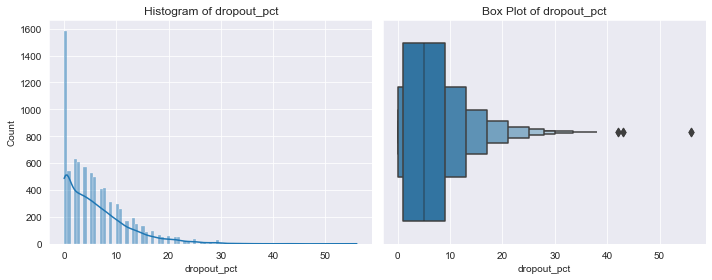

Economic Subgroup Aggregation:


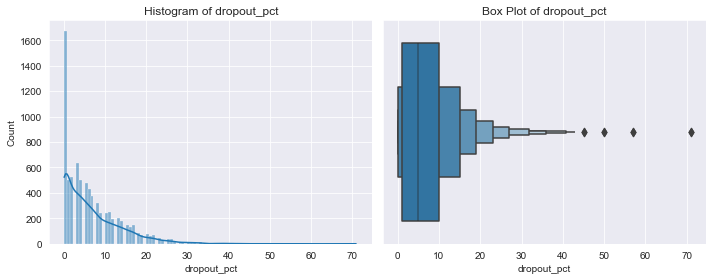

In [66]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, numerics[i])
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, numerics[i])
i += 1

Droput Percentage decays quickly to the right with very few district-cohorts in either aggregation having above 20% dropouts.

#### Constructed Attribute

We construct an additional attribute that is intended to roughly replicate dropout_cnt by multiplying enroll_cnt with dropout_pct.

Outliers in this case are _not_ added to the existing drop sets.

In [67]:
replicate_g = np.array(raw_data_gender['enroll_cnt'])*np.array(raw_data_gender['dropout_pct'])/100
replicate_e = np.array(raw_data_economic['enroll_cnt'])*np.array(raw_data_economic['dropout_pct'])/100

raw_data_gender['replicate'] = replicate_g
raw_data_economic['replicate'] = replicate_e
numerics.append('replicate')

raw_data_gender.shape

(7940, 27)

Gender Subgroup Aggregation:


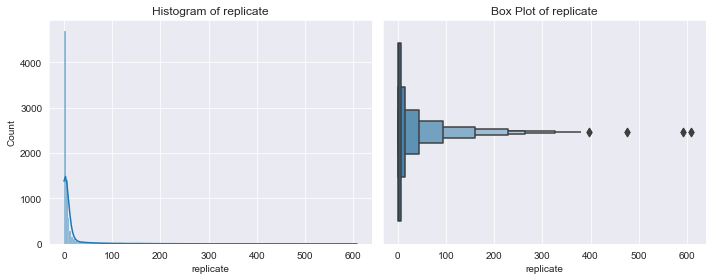

Economic Subgroup Aggregation:


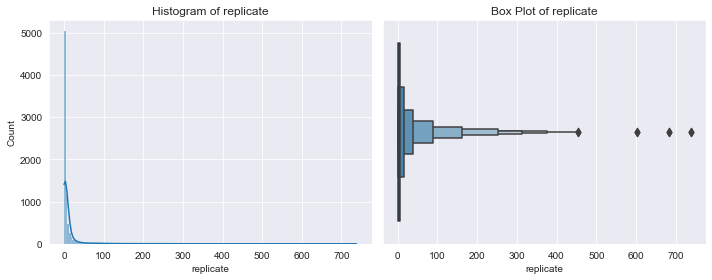

In [68]:
print('Gender Subgroup Aggregation:')
eda_plot(raw_data_gender, 'replicate')
print('Economic Subgroup Aggregation:')
eda_plot(raw_data_economic, 'replicate')

Gender Subgroup Aggregation - Outliers Omitted:


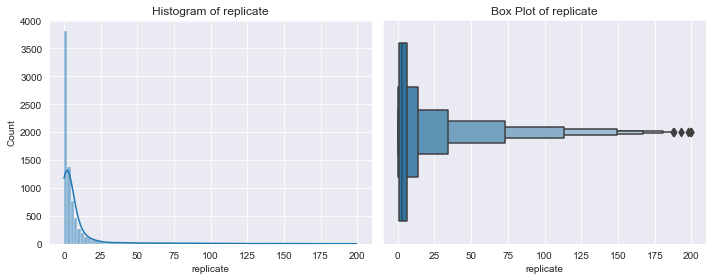

87 outliers omitted.
Economic Subgroup Aggregation - Outliers Omitted:


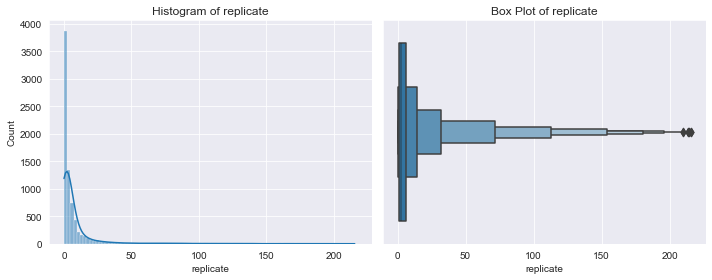

76 outliers omitted.


In [69]:
print('Gender Subgroup Aggregation - Outliers Omitted:')
dropset_fake = cut_outliers(dropset_gen, raw_data_gender, 'replicate')
print('Economic Subgroup Aggregation - Outliers Omitted:')
dropset_fake = cut_outliers(dropset_econ, raw_data_economic, 'replicate')

#### Summary

In [70]:
print('Rolling total outlier count - gender aggregation: ' + str(len(dropset_gen)))
print('Rolling total outlier count - economic aggregation: ' + str(len(dropset_econ)))

Rolling total outlier count - gender aggregation: 199
Rolling total outlier count - economic aggregation: 190


Less than 3% of available data will be lost in the removal of outliers.

### Correlation Matrix

For brevity the correlation matrix is only constructed on the gender subgrouped data, as we have already seen that the economically subgrouped data has largely similar properties.

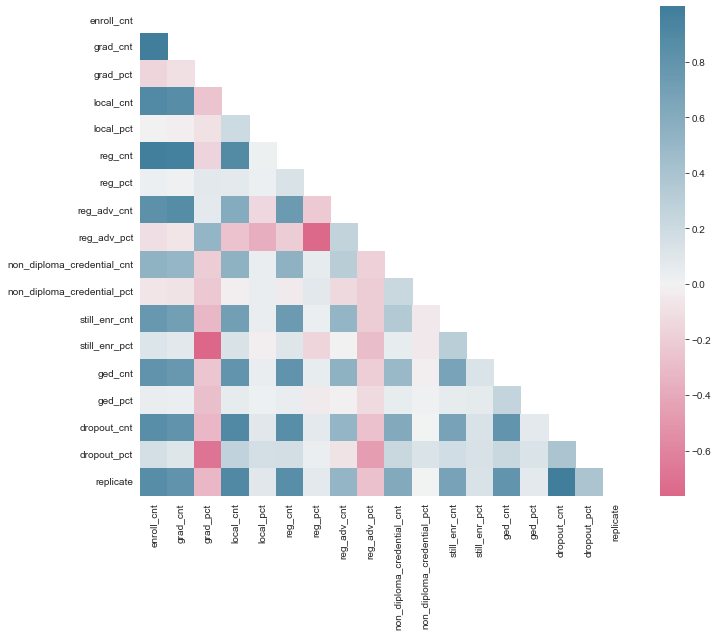

In [71]:
sns.set_style("white")
corr = raw_data_gender[numerics].corr()

mask = np.triu(np.ones_like(corr, dtype = bool))
fig, axes = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(0, 230, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, center = 0, square = True)
plt.show()

Unsurprisingly most of the count variables are positively correlated to enroll_cnt, and the specific types of graduating diploma counts are positively correlated with grad_cnt.

reg_cnt and grad_cnt are so strongly correlated to enroll_cnt and each other that they can be considered collinear, and thus will both be removed for modeling with enroll_cnt alone being sufficient to represent them.

The constructed attribute 'replicate' does have a very high positive correlation to dropout_cnt as expected.

The strongest negative correlations are seen between still_enr_pct and grad_pct (intuitively, students who are still enrolled have not graduated), and between reg_pct and reg_adv_pct. These are not strong enough to be considered cases of collinearity though.

In [72]:
sns.set_style("darkgrid")
useless = set()
useless.add('reg_cnt')
useless.add('grad_cnt')
useless

{'grad_cnt', 'reg_cnt'}

## Categorical Variables

Other than the analysis of the subgroups themselves, this categorical EDA uses the 'All Students' subgrouping.

### Subgroups

As discussed previously, the only subgroups used for modeling will be student gender and economic status due to the availability of almost complete data, whereas the other categories are much more sparse. For the purposes of EDA however we will inspect all subgroup sets.

#### Gender

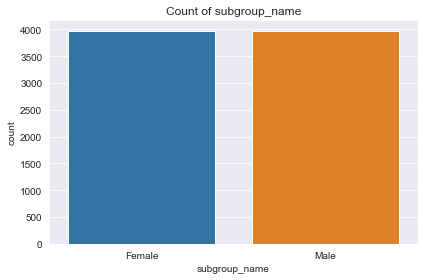

In [73]:
eda_cat_plot(raw_data_gender, 'subgroup_name')

Gender aggregated district-cohorts are a nearly even split.

#### Economic Status

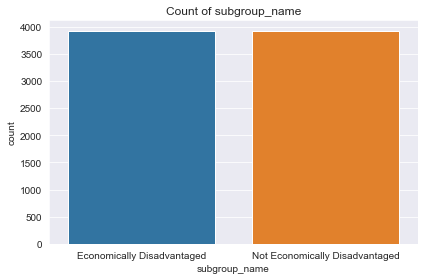

In [74]:
eda_cat_plot(raw_data_economic, 'subgroup_name')

Economically aggregated district-cohorts are also a nearly even split.

#### Race

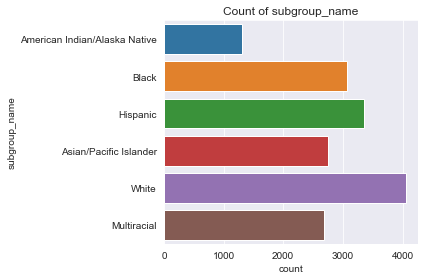

In [75]:
eda_cat_plot(raw_data_race, 'subgroup_name', 0, True)

#### Disability Status

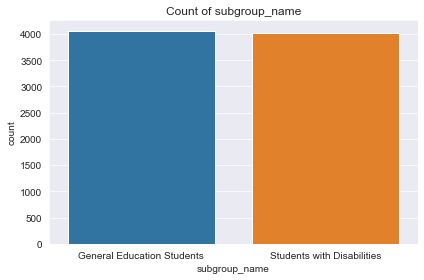

In [76]:
eda_cat_plot(raw_data_disability, 'subgroup_name')

#### English Language Learner Status

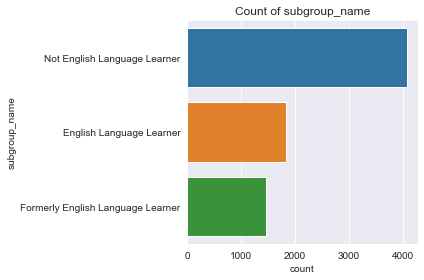

In [77]:
eda_cat_plot(raw_data_ell, 'subgroup_name', 0 ,True)

#### Migrant Status

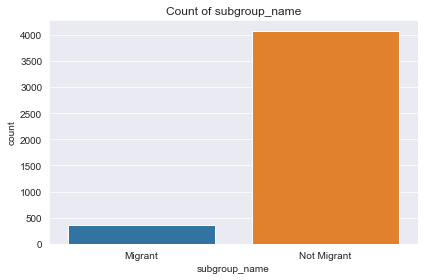

In [78]:
eda_cat_plot(raw_data_migrant, 'subgroup_name')

#### Homelessness

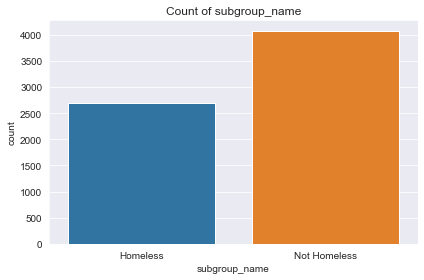

In [79]:
eda_cat_plot(raw_data_homeless, 'subgroup_name')

#### Foster Status

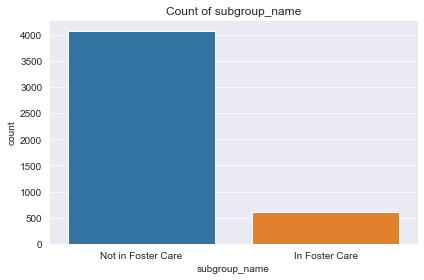

In [80]:
eda_cat_plot(raw_data_foster, 'subgroup_name')

#### Parents in Armed Forces Status

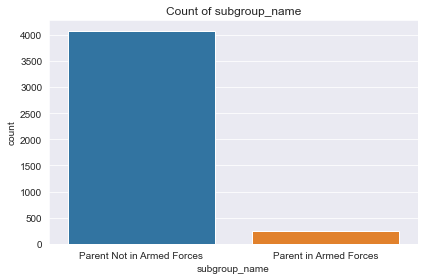

In [81]:
eda_cat_plot(raw_data_armedforces, 'subgroup_name')

### County

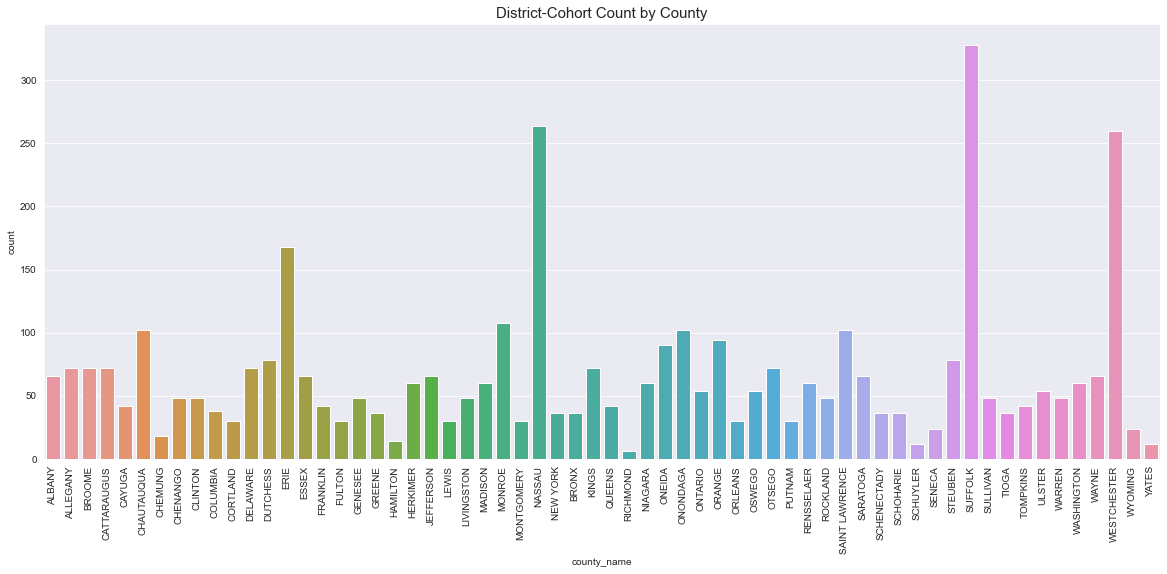

In [82]:
plt.figure(figsize = (20,8))
plt.title('District-Cohort Count by County', size = 15)
plt.xticks(rotation = 90)
sns.countplot(x = 'county_name', data = raw_data_all)
plt.show()

The Long Island counties of Nassau and Suffolk have the most district-cohorts, followed by Westchester county just north of NYC.

### Needs/Resource Category

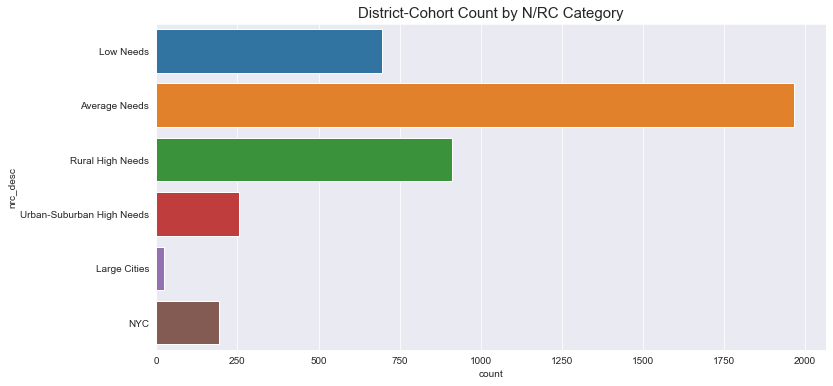

In [83]:
raw_data_all['nrc_desc'] = raw_data_all['nrc_desc'].str.replace(pat = "Buffalo  Rochester  Yonkers  Syracuse", repl = "Large Cities")

ordinal = ('Low Needs', 'Average Needs', 'Rural High Needs',
           'Urban-Suburban High Needs', 'Large Cities', 'NYC')

plt.figure(figsize = (12,6))
plt.title('District-Cohort Count by N/RC Category', size = 15)
sns.countplot(y = 'nrc_desc', data = raw_data_all, order = ordinal)
plt.show()

Needs/Resource Category is considered an ordinal variable (from lowest to highest) due to how the categorization is defined by the New York State Education Department. [https://www.p12.nysed.gov/irs/accountability/2011-12/NeedResourceCapacityIndex.pdf]

### NYC Indicator

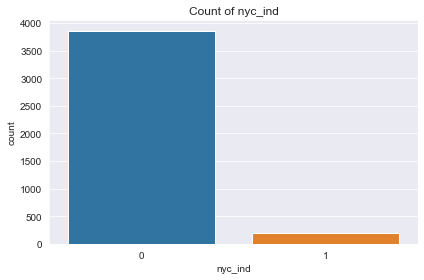

In [84]:
eda_cat_plot(raw_data_all, 'nyc_ind')

The vast majority of district-cohorts in New York State are not in NYC.

### Enrollment Cohort

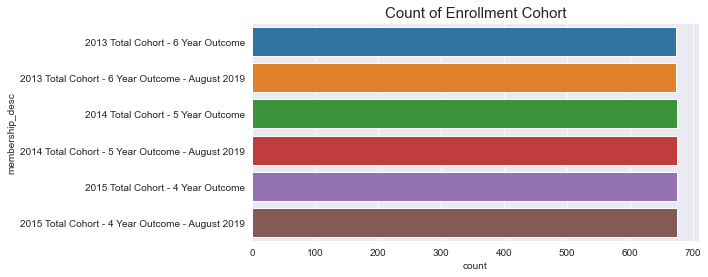

In [85]:
ordinal = ('2013 Total Cohort - 6 Year Outcome', 
           '2013 Total Cohort - 6 Year Outcome - August 2019', 
           '2014 Total Cohort - 5 Year Outcome',
           '2014 Total Cohort - 5 Year Outcome - August 2019',
           '2015 Total Cohort - 4 Year Outcome',
           '2015 Total Cohort - 4 Year Outcome - August 2019')

plt.figure(figsize = (8,4))
plt.title('Count of Enrollment Cohort', size = 15)
sns.countplot(y = 'membership_desc', data = raw_data_all, order = ordinal)
plt.show()

The enrollment cohorts are treated as ordinal due to the varying lengths of time (from longest to shortest) between enrollment and the time when the outcome is being recorded (end of 2018/19 school year).

We see that the counts for each cohort are nearly equal.

# Data Preparation & Review

#### Post-EDA Transform : Numeric

We conduct some basic transformation and filtering informed by our EDA work. This involves the removal of outliers* and the removal of the attributes with apparent bivariate collinearity.

\*(outliers are not numerous enough to justify a full re-analysis, considering that the necessary visualization was previewed in the original EDA)

In [86]:
dataset1 = raw_data_gender[numerics].drop(dropset_gen, axis = 0).drop(useless, axis = 1)

dataset1.shape

(7741, 16)

In [87]:
dataset2 = raw_data_economic[numerics].drop(dropset_econ, axis = 0).drop(useless, axis = 1)

dataset2.shape

(7646, 16)

In [88]:
numeric_predictors = numerics.copy()
target = 'dropout_cnt'
numeric_predictors.remove(target)

for i in useless:
    numeric_predictors.remove(i)

numerics = numeric_predictors + [target]
numeric_predictors

['enroll_cnt',
 'grad_pct',
 'local_cnt',
 'local_pct',
 'reg_pct',
 'reg_adv_cnt',
 'reg_adv_pct',
 'non_diploma_credential_cnt',
 'non_diploma_credential_pct',
 'still_enr_cnt',
 'still_enr_pct',
 'ged_cnt',
 'ged_pct',
 'dropout_pct',
 'replicate']

In [89]:
dataset1.describe()

,enroll_cnt,grad_pct,local_cnt,local_pct,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct,replicate
count,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000
mean,116.139775,88.628472,6.929337,6.223615,43.699651,44.059553,38.735822,1.151014,1.272575,5.066141,3.611807,0.638290,0.512983,7.807389,5.920682,7.821765
std,156.614290,10.972514,12.722746,5.976612,16.000326,57.454471,19.845243,2.307399,2.209121,13.701073,7.547922,1.821037,1.804958,18.822068,6.046240,18.808389
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,85.000000,1.000000,2.000000,34.000000,9.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.950000
50%,63.000000,91.000000,3.000000,5.000000,43.000000,21.000000,38.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,4.000000,2.560000
75%,141.000000,96.000000,7.000000,9.000000,53.000000,59.000000,53.000000,1.000000,2.000000,4.000000,4.000000,0.000000,0.000000,6.000000,9.000000,6.320000
max,1508.000000,100.000000,119.000000,100.000000,100.000000,492.000000,95.000000,26.000000,25.000000,162.000000,100.000000,19.000000,67.000000,190.000000,56.000000,188.100000


In [90]:
dataset2.describe()

,enroll_cnt,grad_pct,local_cnt,local_pct,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct,replicate
count,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000,7646.000000
mean,111.998561,87.451739,6.360842,6.706513,45.026288,44.400994,35.763667,1.054277,1.432121,5.007847,3.903741,0.618493,0.527596,7.559508,6.600183,7.557991
std,155.691520,11.448989,11.061558,5.836013,15.259447,74.024165,20.394295,1.999427,2.603320,13.507460,7.414401,1.830064,1.522522,18.088484,7.103889,18.089646
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,82.000000,1.000000,2.000000,35.000000,7.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.930000
50%,55.000000,90.000000,3.000000,5.000000,45.000000,16.000000,33.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,5.000000,2.240000
75%,127.000000,96.000000,7.000000,10.000000,54.000000,44.000000,51.000000,1.000000,2.000000,4.000000,5.000000,0.000000,0.000000,6.000000,10.000000,6.110000
max,1418.000000,100.000000,144.000000,44.000000,100.000000,569.000000,94.000000,26.000000,23.000000,175.000000,100.000000,21.000000,29.000000,194.000000,71.000000,191.620000


We see that _all_ of our non-negative integer variables are overdispersed, having greater variance than mean. None are actually Poisson. Thus we expect our negative binomial models to be the best performing, followed by Poisson and then linear.

For the purposes of Poisson and negative binomial regressions, no further transformations will be applied to the numeric data; only for linear modeling will further alterations be conducted.

#### Post-EDA Transform : Categorical

In [91]:
categoricals = ['nrc_desc', 'county_name', 'nyc_ind', 'membership_desc', 'subgroup_name']

In [92]:
dataset1_cat = raw_data_gender[categoricals].replace(' Needs', '', regex = True).replace(' Total Cohort -', '', regex = True)
dataset2_cat = raw_data_economic[categoricals].replace(' Needs', '', regex = True).replace(' Total Cohort - ', '', regex = True)
dataset1_cat['nrc_desc'] = dataset1_cat['nrc_desc'].str.replace("Buffalo  Rochester  Yonkers  Syracuse", repl = "Large Cities")
dataset2_cat['nrc_desc'] = dataset2_cat['nrc_desc'].str.replace("Buffalo  Rochester  Yonkers  Syracuse", repl = "Large Cities")

dataset1_cat

,nrc_desc,county_name,nyc_ind,membership_desc,subgroup_name
1,Urban-Suburban High,ALBANY,0,2013 6 Year Outcome,Female
2,Urban-Suburban High,ALBANY,0,2013 6 Year Outcome,Male
23,Urban-Suburban High,ALBANY,0,2014 5 Year Outcome,Female
24,Urban-Suburban High,ALBANY,0,2014 5 Year Outcome,Male
45,Urban-Suburban High,ALBANY,0,2015 4 Year Outcome,Female
...,...,...,...,...,...
73107,Rural High,YATES,0,2014 5 Year Outcome - August 2019,Male
73122,Rural High,YATES,0,2015 4 Year Outcome - August 2019,Female
73123,Rural High,YATES,0,2015 4 Year Outcome - August 2019,Male
73137,Rural High,YATES,0,2013 6 Year Outcome - August 2019,Female


We convert categoricals to dummies:

In [93]:
counties = dict(zip(list(raw_data_all.county_code), list(raw_data_all.county_name)))

nrc_classes = dict(zip(list(raw_data_all.nrc_code), list(raw_data_all.nrc_desc)))

subgroups = dict(zip(list(raw_data.subgroup_code), list(raw_data.subgroup_name)))

nrc_classes

{3: 'Urban-Suburban High Needs',
 5: 'Average Needs',
 6: 'Low Needs',
 4: 'Rural High Needs',
 2: 'Large Cities',
 1: 'NYC'}

In [94]:
nrc1 = pd.get_dummies(dataset1_cat['nrc_desc'], prefix = 'nrc')
nrc2 = pd.get_dummies(dataset2_cat['nrc_desc'], prefix = 'nrc')

nrc1.head(3)

,nrc_Average,nrc_Large Cities,nrc_Low,nrc_NYC,nrc_Rural High,nrc_Urban-Suburban High
1,0,0,0,0,0,1
2,0,0,0,0,0,1
23,0,0,0,0,0,1


In [95]:
county1 = pd.get_dummies(dataset1_cat['county_name'], prefix = 'county')
county2 = pd.get_dummies(dataset2_cat['county_name'], prefix = 'county')

county1.head(3)

,county_ALBANY,county_ALLEGANY,county_BRONX,county_BROOME,county_CATTARAUGUS,county_CAYUGA,county_CHAUTAUQUA,county_CHEMUNG,county_CHENANGO,county_CLINTON,county_COLUMBIA,county_CORTLAND,county_DELAWARE,county_DUTCHESS,county_ERIE,county_ESSEX,county_FRANKLIN,county_FULTON,county_GENESEE,county_GREENE,county_HAMILTON,county_HERKIMER,county_JEFFERSON,county_KINGS,county_LEWIS,county_LIVINGSTON,county_MADISON,county_MONROE,county_MONTGOMERY,county_NASSAU,county_NEW YORK,county_NIAGARA,county_ONEIDA,county_ONONDAGA,county_ONTARIO,county_ORANGE,county_ORLEANS,county_OSWEGO,county_OTSEGO,county_PUTNAM,county_QUEENS,county_RENSSELAER,county_RICHMOND,county_ROCKLAND,county_SAINT LAWRENCE,county_SARATOGA,county_SCHENECTADY,county_SCHOHARIE,county_SCHUYLER,county_SENECA,county_STEUBEN,county_SUFFOLK,county_SULLIVAN,county_TIOGA,county_TOMPKINS,county_ULSTER,county_WARREN,county_WASHINGTON,county_WAYNE,county_WESTCHESTER,county_WYOMING,county_YATES
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
cohort1 = pd.get_dummies(dataset1_cat['membership_desc'], prefix = 'cohort')
cohort2 = pd.get_dummies(dataset2_cat['membership_desc'], prefix = 'cohort')

cohort1.head(3)

,cohort_2013 6 Year Outcome,cohort_2013 6 Year Outcome - August 2019,cohort_2014 5 Year Outcome,cohort_2014 5 Year Outcome - August 2019,cohort_2015 4 Year Outcome,cohort_2015 4 Year Outcome - August 2019
1,1,0,0,0,0,0
2,1,0,0,0,0,0
23,0,0,1,0,0,0


In [97]:
subgroup1 = pd.get_dummies(dataset1_cat['subgroup_name'], prefix = 'gender')
subgroup2 = pd.get_dummies(dataset2_cat['subgroup_name'], prefix = 'econ')

subgroup1.head(3)

,gender_Female,gender_Male
1,1,0
2,0,1
23,1,0


In [98]:
subgroup2.head(3)

,econ_Economically Disadvantaged,econ_Not Economically Disadvantaged
14,1,0
15,0,1
36,1,0


# Regression Models: Poisson & Negative Binomial

We construct several count regression models using 80% of the data available to us, keeping the remaining 20% as a holdout.

We use 4 different feature sets to construct both Poisson and negative binomial models.

**Feature Set 1**:
All numeric variables. (besides the 2 that were removed earlier due to collinearity issues)

**Feature Set 2**:
Just 'replicate'. This is an artificial variable intended to replicate the target dropout_cnt by multiplying dropout_pct and enroll_cnt.

**Feature Set 3**:
All numeric variables except 'replicate', plus categorical N/RC and gender/economic indicator.

**Feature Set 4:**
Best 3 numeric variables from Set 3 (backward selection), plus categorical N/RC and gender/economic indicator.

In [99]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [100]:
complete1 = dataset1.join(nrc1).join(subgroup1['gender_Female'])
complete2 = dataset2.join(nrc2).join(subgroup2['econ_Economically Disadvantaged'])

train1, test1 = train_test_split(complete1, test_size = 0.2, random_state = 42)
train2, test2 = train_test_split(complete2, test_size = 0.2, random_state = 42)

### Feature Set 1

#### Poisson Model

In [101]:
y1 = train1[target]
X1_1 = sm.add_constant(train1[numeric_predictors])

poisson1_1 = sm.GLM(y1, X1_1, family = sm.families.Poisson()).fit()

poisson1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6176
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18994.
Date:                Sun, 26 Jun 2022   Deviance:                       21447.
Time:                        23:53:43   Pearson chi2:                 1.97e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.5114      0.576      0.887      0.375      -0.618       1.641
enroll_cnt                     0.0008   7.68e-05     10.783      0.000       0.001       0.001
grad_pct                      -0.0119      0.009     -1.298      0.194      -0.030       0.006
local_cnt                      0.0071      0.000     15.680      0.000       0.006       0.008
local_pct                      0.0151      0.008      1.848      0.065      -0.001       0.031
reg_pct                        0.0183      0.008      2.257      0.024       0.002       0.034
reg_adv_cnt                    0.0022      0.000     14.494      0.000       0.002       0.002
reg_adv_pct                    0.0079      0.008      0.972      0.331      -0.008       0.024
non_diploma_credential_cnt     0.0162      0.001     12.097      0.000       0.014       0.019
non_diploma_credential_pct    -0.0173      0.006     -2.733      0.006      -0.030      -0.005
still_enr_cnt                  0.0048      0.000     19.781      0.000       0.004       0.005
still_enr_pct                  0.0036      0.006      0.618      0.537      -0.008       0.015
ged_cnt                        0.0223      0.002     12.005      0.000       0.019       0.026
ged_pct                        0.0032      0.006      0.495      0.620      -0.009       0.016
dropout_pct                    0.0808      0.006     13.945      0.000       0.069       0.092
replicate                      0.0050      0.000     20.570      0.000       0.005       0.005
==============================================================================================
"""

In [102]:
y2 = train2[target]
X1_2 = sm.add_constant(train2[numeric_predictors])

poisson1_2 = sm.GLM(y2, X1_2, family = sm.families.Poisson()).fit()

poisson1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6100
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18871.
Date:                Sun, 26 Jun 2022   Deviance:                       21629.
Time:                        23:53:43   Pearson chi2:                 2.00e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.1534      0.639      1.806      0.071      -0.098       2.405
enroll_cnt                     0.0013   6.91e-05     18.271      0.000       0.001       0.001
grad_pct                       0.0254      0.010      2.586      0.010       0.006       0.045
local_cnt                      0.0053      0.000     13.909      0.000       0.005       0.006
local_pct                     -0.0269      0.009     -3.158      0.002      -0.044      -0.010
reg_pct                       -0.0252      0.009     -2.964      0.003      -0.042      -0.009
reg_adv_cnt                    0.0027      0.000     24.314      0.000       0.003       0.003
reg_adv_pct                   -0.0406      0.009     -4.765      0.000      -0.057      -0.024
non_diploma_credential_cnt     0.0173      0.001     12.986      0.000       0.015       0.020
non_diploma_credential_pct    -0.0339      0.007     -5.031      0.000      -0.047      -0.021
still_enr_cnt                  0.0036      0.000     14.985      0.000       0.003       0.004
still_enr_pct                  0.0063      0.006      0.970      0.332      -0.006       0.019
ged_cnt                       -0.0145      0.002     -9.326      0.000      -0.018      -0.011
ged_pct                        0.0440      0.007      6.217      0.000       0.030       0.058
dropout_pct                    0.0677      0.006     10.512      0.000       0.055       0.080
replicate                      0.0051      0.000     20.653      0.000       0.005       0.006
==============================================================================================
"""

#### Negative Binomial Model

A small value of alpha (which can effectively be varied between 0.01 and 2 in statsmodels) is chosen so as to not deviate too drastically from the Poisson baseline (~ alpha = 0).

In [103]:
alpha = 0.05

negbinom1_1 = sm.GLM(y1, X1_1, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6176
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15174.
Date:                Sun, 26 Jun 2022   Deviance:                       12320.
Time:                        23:53:43   Pearson chi2:                 9.93e+03
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.5804      0.826     -1.913      0.056      -3.199       0.039
enroll_cnt                     0.0009      0.000      6.002      0.000       0.001       0.001
grad_pct                       0.0153      0.013      1.148      0.251      -0.011       0.041
local_cnt                      0.0091      0.001      9.747      0.000       0.007       0.011
local_pct                      0.0042      0.012      0.353      0.724      -0.019       0.027
reg_pct                        0.0070      0.012      0.596      0.551      -0.016       0.030
reg_adv_cnt                    0.0052      0.000     20.328      0.000       0.005       0.006
reg_adv_pct                   -0.0022      0.012     -0.185      0.854      -0.025       0.021
non_diploma_credential_cnt     0.0272      0.003      9.266      0.000       0.021       0.033
non_diploma_credential_pct    -0.0143      0.009     -1.605      0.108      -0.032       0.003
still_enr_cnt                  0.0064      0.001     12.627      0.000       0.005       0.007
still_enr_pct                  0.0159      0.008      1.902      0.057      -0.000       0.032
ged_cnt                        0.0225      0.003      6.570      0.000       0.016       0.029
ged_pct                        0.0186      0.009      2.052      0.040       0.001       0.036
dropout_pct                    0.1254      0.008     15.033      0.000       0.109       0.142
replicate                      0.0042      0.001      7.740      0.000       0.003       0.005
==============================================================================================
"""

In [104]:
negbinom1_2 = sm.GLM(y2, X1_2, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6100
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14896.
Date:                Sun, 26 Jun 2022   Deviance:                       12238.
Time:                        23:53:43   Pearson chi2:                 1.02e+04
No. Iterations:                    19   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.0169      0.849      2.376      0.017       0.353       3.680
enroll_cnt                     0.0028      0.000     17.439      0.000       0.002       0.003
grad_pct                       0.0199      0.014      1.454      0.146      -0.007       0.047
local_cnt                      0.0084      0.001      9.337      0.000       0.007       0.010
local_pct                     -0.0363      0.012     -3.093      0.002      -0.059      -0.013
reg_pct                       -0.0351      0.012     -2.995      0.003      -0.058      -0.012
reg_adv_cnt                    0.0007      0.000      3.083      0.002       0.000       0.001
reg_adv_pct                   -0.0416      0.012     -3.551      0.000      -0.065      -0.019
non_diploma_credential_cnt     0.0369      0.003     11.474      0.000       0.031       0.043
non_diploma_credential_pct    -0.0590      0.009     -6.502      0.000      -0.077      -0.041
still_enr_cnt                  0.0035      0.000      6.950      0.000       0.002       0.004
still_enr_pct                 -0.0104      0.009     -1.211      0.226      -0.027       0.006
ged_cnt                       -0.0255      0.003     -7.333      0.000      -0.032      -0.019
ged_pct                        0.0304      0.010      3.154      0.002       0.011       0.049
dropout_pct                    0.0753      0.009      8.807      0.000       0.059       0.092
replicate                      0.0030      0.001      5.383      0.000       0.002       0.004
==============================================================================================
"""

The negative binomial models achieve a higher log-likelihood than the Poisson models, indicating a better training fit.

### Feature Set 2

#### Poisson Model

In [105]:
X2_1 = sm.add_constant(train1['replicate'])

poisson2_1 = sm.GLM(y1, X2_1, family = sm.families.Poisson()).fit()

poisson2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6190
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27206.
Date:                Sun, 26 Jun 2022   Deviance:                       37873.
Time:                        23:53:43   Pearson chi2:                 3.79e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5025      0.006    259.363      0.000       1.491       1.514
replicate      0.0260   6.92e-05    375.121      0.000       0.026       0.026
==============================================================================
"""

In [106]:
X2_2 = sm.add_constant(train2['replicate'])

poisson2_2 = sm.GLM(y2, X2_2, family = sm.families.Poisson()).fit()

poisson2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6114
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27482.
Date:                Sun, 26 Jun 2022   Deviance:                       38851.
Time:                        23:53:43   Pearson chi2:                 3.94e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5041      0.006    258.165      0.000       1.493       1.516
replicate      0.0254   6.92e-05    367.710      0.000       0.025       0.026
==============================================================================
"""

#### Negative Binomial Model

In [107]:
negbinom2_1 = sm.GLM(y1, X2_1, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6190
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19209.
Date:                Sun, 26 Jun 2022   Deviance:                       20390.
Time:                        23:53:43   Pearson chi2:                 1.68e+04
No. Iterations:                    23   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2070      0.007    163.941      0.000       1.193       1.221
replicate      0.0414      0.000    231.075      0.000       0.041       0.042
==============================================================================
"""

In [108]:
negbinom2_2 = sm.GLM(y2, X2_2, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6114
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19103.
Date:                Sun, 26 Jun 2022   Deviance:                       20652.
Time:                        23:53:43   Pearson chi2:                 1.68e+04
No. Iterations:                    25   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1892      0.007    160.020      0.000       1.175       1.204
replicate      0.0427      0.000    232.376      0.000       0.042       0.043
==============================================================================
"""

The 'replicate' models have weaker fits than the all-numerics models but once again the negative binomials achieve higher log-likelihoods. However the coefficients in the negative binomial models are larger, which means that the actually near linear relation between the constructed variable and the target is not being modeled as well as in the Poisson models.

### Feature Set 3

#### Poisson Model

In [109]:
X3_1 = sm.add_constant(train1.drop(['dropout_cnt', 'replicate'], axis = 1))

poisson3_1 = sm.GLM(y1, X3_1, family = sm.families.Poisson()).fit()

poisson3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6171
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16832.
Date:                Sun, 26 Jun 2022   Deviance:                       17124.
Time:                        23:53:44   Pearson chi2:                 1.61e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.4543      0.504      2.887      0.004       0.467       2.442
enroll_cnt                     0.0012   7.06e-05     16.795      0.000       0.001       0.001
grad_pct                      -0.0184      0.009     -2.004      0.045      -0.036      -0.000
local_cnt                      0.0106      0.001     20.953      0.000       0.010       0.012
local_pct                      0.0064      0.008      0.775      0.438      -0.010       0.023
reg_pct                        0.0124      0.008      1.513      0.130      -0.004       0.028
reg_adv_cnt                    0.0014      0.000      9.946      0.000       0.001       0.002
reg_adv_pct                    0.0067      0.008      0.819      0.413      -0.009       0.023
non_diploma_credential_cnt     0.0214      0.001     15.237      0.000       0.019       0.024
non_diploma_credential_pct    -0.0357      0.007     -5.489      0.000      -0.048      -0.023
still_enr_cnt                  0.0031      0.000     11.987      0.000       0.003       0.004
still_enr_pct                 -0.0116      0.006     -1.949      0.051      -0.023    6.65e-05
ged_cnt                        0.0194      0.002      9.939      0.000       0.016       0.023
ged_pct                       -0.0194      0.007     -2.858      0.004      -0.033      -0.006
dropout_pct                    0.0684      0.006     11.576      0.000       0.057       0.080
nrc_Average                    0.3117      0.085      3.680      0.000       0.146       0.478
nrc_Large Cities               0.2387      0.090      2.641      0.008       0.062       0.416
nrc_Low                       -0.3164      0.087     -3.633      0.000      -0.487      -0.146
nrc_NYC                        0.4934      0.087      5.660      0.000       0.323       0.664
nrc_Rural High                -0.1863      0.085     -2.190      0.029      -0.353      -0.020
nrc_Urban-Suburban High        0.9132      0.085     10.761      0.000       0.747       1.080
gender_Female                 -0.1082      0.010    -10.559      0.000      -0.128      -0.088
==============================================================================================
"""

In [110]:
X3_2 = sm.add_constant(train2.drop(['dropout_cnt', 'replicate'], axis = 1))

poisson3_2 = sm.GLM(y2, X3_2, family = sm.families.Poisson()).fit()

poisson3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6095
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16902.
Date:                Sun, 26 Jun 2022   Deviance:                       17689.
Time:                        23:53:44   Pearson chi2:                 1.69e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.3389      0.560      2.390      0.017       0.241       2.437
enroll_cnt                          0.0016    5.8e-05     27.804      0.000       0.001       0.002
grad_pct                            0.0172      0.010      1.742      0.081      -0.002       0.037
local_cnt                           0.0036      0.000      8.574      0.000       0.003       0.004
local_pct                          -0.0196      0.009     -2.308      0.021      -0.036      -0.003
reg_pct                            -0.0204      0.008     -2.405      0.016      -0.037      -0.004
reg_adv_cnt                         0.0019      0.000     16.993      0.000       0.002       0.002
reg_adv_pct                        -0.0300      0.009     -3.528      0.000      -0.047      -0.013
non_diploma_credential_cnt          0.0173      0.001     12.744      0.000       0.015       0.020
non_diploma_credential_pct         -0.0317      0.007     -4.566      0.000      -0.045      -0.018
still_enr_cnt                       0.0020      0.000      7.634      0.000       0.001       0.002
still_enr_pct                      -0.0018      0.007     -0.271      0.786      -0.015       0.011
ged_cnt                            -0.0069      0.002     -4.178      0.000      -0.010      -0.004
ged_pct                             0.0248      0.007      3.353      0.001       0.010       0.039
dropout_pct                         0.0646      0.007      9.805      0.000       0.052       0.077
nrc_Average                         0.0252      0.094      0.268      0.788      -0.159       0.209
nrc_Large Cities                    0.9374      0.098      9.614      0.000       0.746       1.129
nrc_Low                            -0.5761      0.096     -6.024      0.000      -0.764      -0.389
nrc_NYC                             0.6588      0.096      6.885      0.000       0.471       0.846
nrc_Rural High                     -0.3892      0.095     -4.116      0.000      -0.575      -0.204
nrc_Urban-Suburban High             0.6827      0.094      7.246      0.000       0.498       0.867
econ_Economically Disadvantaged     0.0546      0.014      4.006      0.000       0.028       0.081
===================================================================================================
"""

#### Negative Binomial Model

In [111]:
negbinom3_1 = sm.GLM(y1, X3_1, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6171
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14252.
Date:                Sun, 26 Jun 2022   Deviance:                       10477.
Time:                        23:53:44   Pearson chi2:                 8.76e+03
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.3376      0.727     -1.841      0.066      -2.762       0.086
enroll_cnt                     0.0012      0.000      9.166      0.000       0.001       0.002
grad_pct                       0.0108      0.014      0.801      0.423      -0.016       0.037
local_cnt                      0.0136      0.001     13.921      0.000       0.012       0.016
local_pct                      0.0047      0.012      0.393      0.694      -0.019       0.028
reg_pct                        0.0096      0.012      0.810      0.418      -0.014       0.033
reg_adv_cnt                    0.0043      0.000     17.106      0.000       0.004       0.005
reg_adv_pct                    0.0036      0.012      0.301      0.763      -0.020       0.027
non_diploma_credential_cnt     0.0302      0.003     10.112      0.000       0.024       0.036
non_diploma_credential_pct    -0.0156      0.009     -1.706      0.088      -0.034       0.002
still_enr_cnt                  0.0061      0.001     11.458      0.000       0.005       0.007
still_enr_pct                  0.0119      0.009      1.384      0.166      -0.005       0.029
ged_cnt                        0.0276      0.004      7.735      0.000       0.021       0.035
ged_pct                        0.0028      0.010      0.288      0.773      -0.016       0.022
dropout_pct                    0.1182      0.009     13.851      0.000       0.101       0.135
nrc_Average                    0.0571      0.123      0.466      0.641      -0.183       0.297
nrc_Large Cities              -0.7196      0.140     -5.144      0.000      -0.994      -0.445
nrc_Low                       -0.5879      0.125     -4.699      0.000      -0.833      -0.343
nrc_NYC                       -0.2033      0.127     -1.604      0.109      -0.452       0.045
nrc_Rural High                -0.3305      0.123     -2.693      0.007      -0.571      -0.090
nrc_Urban-Suburban High        0.4465      0.123      3.644      0.000       0.206       0.687
gender_Female                 -0.1002      0.015     -6.811      0.000      -0.129      -0.071
==============================================================================================
"""

In [112]:
negbinom3_2 = sm.GLM(y2, X3_2, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6095
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14252.
Date:                Sun, 26 Jun 2022   Deviance:                       10951.
Time:                        23:53:44   Pearson chi2:                 9.33e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.1693      0.741      2.929      0.003       0.718       3.621
enroll_cnt                          0.0025      0.000     19.527      0.000       0.002       0.003
grad_pct                            0.0203      0.014      1.472      0.141      -0.007       0.047
local_cnt                           0.0086      0.001      9.389      0.000       0.007       0.010
local_pct                          -0.0394      0.012     -3.343      0.001      -0.063      -0.016
reg_pct                            -0.0395      0.012     -3.351      0.001      -0.063      -0.016
reg_adv_cnt                         0.0012      0.000      5.971      0.000       0.001       0.002
reg_adv_pct                        -0.0454      0.012     -3.852      0.000      -0.068      -0.022
non_diploma_credential_cnt          0.0321      0.003     10.125      0.000       0.026       0.038
non_diploma_credential_pct         -0.0565      0.009     -6.118      0.000      -0.075      -0.038
still_enr_cnt                       0.0030      0.001      5.697      0.000       0.002       0.004
still_enr_pct                      -0.0166      0.009     -1.906      0.057      -0.034       0.000
ged_cnt                            -0.0130      0.004     -3.690      0.000      -0.020      -0.006
ged_pct                             0.0095      0.010      0.955      0.339      -0.010       0.029
dropout_pct                         0.0690      0.009      7.943      0.000       0.052       0.086
nrc_Average                         0.3616      0.125      2.899      0.004       0.117       0.606
nrc_Large Cities                    0.7852      0.135      5.801      0.000       0.520       1.050
nrc_Low                            -0.1885      0.127     -1.490      0.136      -0.437       0.059
nrc_NYC                             0.4356      0.128      3.400      0.001       0.184       0.687
nrc_Rural High                      0.0127      0.125      0.101      0.919      -0.233       0.258
nrc_Urban-Suburban High             0.7629      0.125      6.086      0.000       0.517       1.009
econ_Economically Disadvantaged     0.0054      0.019      0.283      0.777      -0.032       0.043
===================================================================================================
"""

The addition of categorical data results in higher log-likelihood for both Poisson and negative binomial models compared to Feature Set 1.

Strangely, the economic status categorical variable is considered statistically significant in the Poisson model but not in the negative binomial model. The gender categorical variable is significant in both.

### Feature Set 4

Inspecting the results of the models from Feature Set 3, the 3 most consistently significant numeric attributes (as measured by minimum p-value) were enroll_cnt, dropout_pct and still_enr_cnt. Thus these will be the numeric variables selected for this feature set.

#### Poisson Model

In [113]:
droplist = ['grad_pct', 'local_cnt', 'local_pct', 'reg_pct', 'reg_adv_cnt', 
            'reg_adv_pct', 'non_diploma_credential_cnt', 'non_diploma_credential_pct', 
            'still_enr_pct', 'ged_cnt', 'ged_pct', 'dropout_cnt', 'replicate']

X4_1 = sm.add_constant(train1.drop(droplist, axis = 1))

poisson4_1 = sm.GLM(y1, X4_1, family = sm.families.Poisson()).fit()

poisson4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6182
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17354.
Date:                Sun, 26 Jun 2022   Deviance:                       18168.
Time:                        23:53:44   Pearson chi2:                 1.72e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.8995      0.013     69.473      0.000       0.874       0.925
enroll_cnt                  0.0023   2.22e-05    101.929      0.000       0.002       0.002
still_enr_cnt               0.0013      0.000      6.960      0.000       0.001       0.002
dropout_pct                 0.0785      0.001    123.987      0.000       0.077       0.080
nrc_Average                -0.0094      0.011     -0.884      0.377      -0.030       0.011
nrc_Large Cities            0.6578      0.027     24.617      0.000       0.605       0.710
nrc_Low                    -0.6485      0.021    -31.575      0.000      -0.689      -0.608
nrc_NYC                     0.7132      0.016     44.080      0.000       0.681       0.745
nrc_Rural High             -0.5061      0.015    -33.895      0.000      -0.535      -0.477
nrc_Urban-Suburban High     0.6925      0.011     60.618      0.000       0.670       0.715
gender_Female              -0.1790      0.010    -18.555      0.000      -0.198      -0.160
===========================================================================================
"""

In [114]:
X4_2 = sm.add_constant(train2.drop(droplist, axis = 1))

poisson4_2 = sm.GLM(y2, X4_2, family = sm.families.Poisson()).fit()

poisson4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6106
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17247.
Date:                Sun, 26 Jun 2022   Deviance:                       18380.
Time:                        23:53:44   Pearson chi2:                 1.79e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.8146      0.011     74.185      0.000       0.793       0.836
enroll_cnt                          0.0023   2.03e-05    112.968      0.000       0.002       0.002
still_enr_cnt                       0.0011      0.000      5.906      0.000       0.001       0.001
dropout_pct                         0.0714      0.001    137.313      0.000       0.070       0.072
nrc_Average                        -0.1541      0.011    -14.487      0.000      -0.175      -0.133
nrc_Large Cities                    0.9843      0.028     34.636      0.000       0.929       1.040
nrc_Low                            -0.7797      0.021    -37.988      0.000      -0.820      -0.739
nrc_NYC                             0.7358      0.014     51.285      0.000       0.708       0.764
nrc_Rural High                     -0.5661      0.015    -38.470      0.000      -0.595      -0.537
nrc_Urban-Suburban High             0.5944      0.011     51.702      0.000       0.572       0.617
econ_Economically Disadvantaged     0.1743      0.010     17.629      0.000       0.155       0.194
===================================================================================================
"""

#### Negative Binomial Model

In [115]:
negbinom4_1 = sm.GLM(y1, X4_1, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6192
Model:                            GLM   Df Residuals:                     6182
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14486.
Date:                Sun, 26 Jun 2022   Deviance:                       10945.
Time:                        23:53:44   Pearson chi2:                 9.06e+03
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2181      0.022      9.893      0.000       0.175       0.261
enroll_cnt                  0.0039   4.48e-05     86.851      0.000       0.004       0.004
still_enr_cnt               0.0018      0.000      4.535      0.000       0.001       0.003
dropout_pct                 0.0999      0.001     97.083      0.000       0.098       0.102
nrc_Average                 0.2650      0.016     16.102      0.000       0.233       0.297
nrc_Large Cities           -0.3415      0.061     -5.643      0.000      -0.460      -0.223
nrc_Low                    -0.3475      0.025    -13.968      0.000      -0.396      -0.299
nrc_NYC                     0.1224      0.030      4.105      0.000       0.064       0.181
nrc_Rural High             -0.1352      0.021     -6.368      0.000      -0.177      -0.094
nrc_Urban-Suburban High     0.6550      0.019     33.963      0.000       0.617       0.693
gender_Female              -0.1503      0.014    -10.913      0.000      -0.177      -0.123
===========================================================================================
"""

In [116]:
negbinom4_2 = sm.GLM(y2, X4_2, family = sm.families.NegativeBinomial(alpha = alpha)).fit()

negbinom4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                 6116
Model:                            GLM   Df Residuals:                     6106
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14454.
Date:                Sun, 26 Jun 2022   Deviance:                       11355.
Time:                        23:53:44   Pearson chi2:                 9.89e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.3438      0.018     19.429      0.000       0.309       0.379
enroll_cnt                          0.0035   4.03e-05     87.328      0.000       0.003       0.004
still_enr_cnt                       0.0026      0.000      6.411      0.000       0.002       0.003
dropout_pct                         0.0910      0.001    104.064      0.000       0.089       0.093
nrc_Average                        -0.0341      0.016     -2.195      0.028      -0.065      -0.004
nrc_Large Cities                    0.6607      0.058     11.419      0.000       0.547       0.774
nrc_Low                            -0.6248      0.024    -25.637      0.000      -0.673      -0.577
nrc_NYC                             0.2561      0.027      9.324      0.000       0.202       0.310
nrc_Rural High                     -0.3783      0.020    -19.263      0.000      -0.417      -0.340
nrc_Urban-Suburban High             0.4642      0.019     24.618      0.000       0.427       0.501
econ_Economically Disadvantaged     0.1543      0.015     10.288      0.000       0.125       0.184
===================================================================================================
"""

Narrowing down to only 3 numeric attributes does not seem to result in much loss of fit compared to Feature Set 3, but it is nonetheless a little weaker. Both subgroup categorical variables remain statistically significant.

### Model Selection

We have seen at a glance the performance of our models on training data, but to better evaluate them we need to test on unseen data. To this end we will compare them on our test data using a simple root mean squared error (RMSE) metric.

**Data Set 1 (Gender Subgrouped):**

In [117]:
y = test1[target]

X = sm.add_constant(test1[numeric_predictors])
y_pred = poisson1_1.predict(X)
print("Poisson Model - Feature Set 1:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom1_1.predict(X)
print("Negative Binomial Model - Feature Set 1:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test1['replicate'])
y_pred = poisson2_1.predict(X)
print("Poisson Model - Feature Set 2:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom2_1.predict(X)
print("Negative Binomial Model - Feature Set 2:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test1.drop(['dropout_cnt', 'replicate'], axis = 1))
y_pred = poisson3_1.predict(X)
print("Poisson Model - Feature Set 3:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom3_1.predict(X)
print("Negative Binomial Model - Feature Set 3:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test1.drop(droplist, axis = 1))
y_pred = poisson4_1.predict(X)
print("Poisson Model - Feature Set 4:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom4_1.predict(X)
print("Negative Binomial Model - Feature Set 4:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

Poisson Model - Feature Set 1:
9.925

Negative Binomial Model - Feature Set 1:
39.87

Poisson Model - Feature Set 2:
16.207

Negative Binomial Model - Feature Set 2:
274.715

Poisson Model - Feature Set 3:
7.674

Negative Binomial Model - Feature Set 3:
27.311

Poisson Model - Feature Set 4:
9.269

Negative Binomial Model - Feature Set 4:
39.527



**Data Set 2 (Economic Subgrouped):**

In [118]:
y = test2[target]

X = sm.add_constant(test2[numeric_predictors])
y_pred = poisson1_2.predict(X)
print("Poisson Model - Feature Set 1:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom1_2.predict(X)
print("Negative Binomial Model - Feature Set 1:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test2['replicate'])
y_pred = poisson2_2.predict(X)
print("Poisson Model - Feature Set 2:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom2_2.predict(X)
print("Negative Binomial Model - Feature Set 2:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test2.drop(['dropout_cnt', 'replicate'], axis = 1))
y_pred = poisson3_2.predict(X)
print("Poisson Model - Feature Set 3:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom3_2.predict(X)
print("Negative Binomial Model - Feature Set 3:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

X = sm.add_constant(test2.drop(droplist, axis = 1))
y_pred = poisson4_2.predict(X)
print("Poisson Model - Feature Set 4:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

y_pred = negbinom4_2.predict(X)
print("Negative Binomial Model - Feature Set 4:\n" + str(round(mean_squared_error(y, y_pred, squared = False), 3)) + "\n")

Poisson Model - Feature Set 1:
11.198

Negative Binomial Model - Feature Set 1:
59.216

Poisson Model - Feature Set 2:
18.519

Negative Binomial Model - Feature Set 2:
478.656

Poisson Model - Feature Set 3:
11.845

Negative Binomial Model - Feature Set 3:
40.035

Poisson Model - Feature Set 4:
15.878

Negative Binomial Model - Feature Set 4:
44.784



The surprising takeaway here is that the negative binomial models performed much worse than the Poisson models, and the count regression models built using the 'replicate' variable alone are not useful at all; this variable will perhaps be more useful in linear models.

Of these models the one we would select would be the Poisson models using Feature Set 3 - all numerics other than 'replicate' plus N/RC and subgroup-specific categoricals.

# Regression Models: Linear

In [119]:
import scipy
import statsmodels.api as sm

#### Transforming data: 

Due to the nature of the data distribution, we will use a power transform instead of normalization.
Due to some negative values, we use Yeo-Johnson instead of Box-Cox.

In [120]:
def boxcox(df):
    for column in df.columns:
        df[column] = scipy.stats.yeojohnson(df[column])[0]
    return df

In [121]:
transformed_df1 = boxcox(dataset1)
transformed_df1

,enroll_cnt,grad_pct,local_cnt,local_pct,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct,replicate
1,4.685538,4.980589e+07,2.573609,3.173613,25.411901,4.535844,10.064249,0.653793,0.488796,1.424341,1.146661,-0.000000,-0.000000,2.410400,3.882236,2.437971
2,4.705091,2.518899e+07,2.623518,3.351384,21.495121,4.448170,8.928909,0.901552,0.765696,1.554904,1.496239,-0.000000,-0.000000,2.478437,4.228902,2.510668
23,4.707012,4.980589e+07,2.573609,3.173613,24.643995,4.842485,11.713430,0.732770,0.488796,1.543245,1.405403,0.297685,0.231607,2.355668,3.550264,2.380246
24,4.722159,2.354437e+07,2.639012,3.351384,21.495121,4.386680,8.348666,0.886661,0.720942,1.610092,1.571785,0.290905,0.231607,2.487942,4.228902,2.518007
45,4.720287,3.479098e+07,2.295055,2.293768,25.028842,4.535844,9.500540,0.653793,0.488796,1.717065,1.891461,0.290905,0.231607,2.325869,3.358655,2.344521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73107,2.999275,1.203457e+08,1.739854,5.083876,23.868756,2.105140,13.308793,0.493394,0.720942,-0.000000,-0.000000,-0.000000,-0.000000,0.627161,1.545051,0.572998
73122,2.791715,6.940605e+07,1.229391,3.961992,26.550754,1.465889,9.500540,0.493394,0.795084,0.845805,1.691827,-0.000000,-0.000000,0.627161,2.062763,0.668351
73123,3.180464,6.578341e+07,1.535562,3.961992,30.245814,0.712677,2.520345,0.493394,0.720942,1.000736,1.636091,-0.000000,-0.000000,1.138827,2.613763,1.137223
73137,2.888006,6.230886e+07,0.652335,2.007507,26.927058,1.926195,12.782383,0.653793,0.843047,0.586016,1.292723,-0.000000,-0.000000,0.939024,2.613763,0.942445


**Below we use a correlation matrix to find explanitory variables to use in our regresssion model**

In [122]:
transformed_df1.corr()

,enroll_cnt,grad_pct,local_cnt,local_pct,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct,replicate
enroll_cnt,1.000000,-0.033118,0.720344,0.026980,-0.136320,0.798223,0.148222,0.409022,0.119317,0.633061,0.283752,0.368628,0.283191,0.610001,0.090856,0.600419
grad_pct,-0.033118,1.000000,-0.217657,-0.191493,-0.019935,0.192311,0.523308,-0.358063,-0.353287,-0.435918,-0.546295,-0.252912,-0.253550,-0.614177,-0.775506,-0.612954
local_cnt,0.720344,-0.217657,1.000000,0.658982,-0.008189,0.478936,-0.174682,0.407034,0.172322,0.528681,0.266679,0.337788,0.263569,0.643164,0.271429,0.637303
local_pct,0.026980,-0.191493,0.658982,1.000000,0.077175,-0.124918,-0.346914,0.126067,0.116861,0.056048,0.053085,0.064173,0.059820,0.227841,0.240772,0.229999
reg_pct,-0.136320,-0.019935,-0.008189,0.077175,1.000000,-0.512551,-0.743815,0.041838,0.069907,-0.117986,-0.101770,-0.026567,-0.017898,0.008301,0.062437,0.014096
reg_adv_cnt,0.798223,0.192311,0.478936,-0.124918,-0.512551,1.000000,0.648517,0.257990,0.022578,0.429547,0.118814,0.252213,0.178358,0.383257,-0.082220,0.372209
reg_adv_pct,0.148222,0.523308,-0.174682,-0.346914,-0.743815,0.648517,1.000000,-0.158610,-0.176599,-0.114411,-0.204013,-0.082935,-0.089536,-0.240182,-0.390603,-0.244960
non_diploma_credential_cnt,0.409022,-0.358063,0.407034,0.126067,0.041838,0.257990,-0.158610,1.000000,0.893791,0.265313,0.114209,0.261486,0.219203,0.437521,0.240463,0.432580
non_diploma_credential_pct,0.119317,-0.353287,0.172322,0.116861,0.069907,0.022578,-0.176599,0.893791,1.000000,0.046537,0.018662,0.130387,0.134444,0.236673,0.208345,0.237371
still_enr_cnt,0.633061,-0.435918,0.528681,0.056048,-0.117986,0.429547,-0.114411,0.265313,0.046537,1.000000,0.880183,0.293935,0.225199,0.507218,0.171932,0.499887


In [123]:
transformed_df1 = sm.add_constant(transformed_df1)

In [124]:
'''We use some of the variables which have a higher correlation to dropout_cnt'''
explanitory_cols = ['local_cnt', 'reg_adv_cnt', 'still_enr_cnt', 'replicate']
response_col = 'dropout_pct'

#### We use ordinary least squares to build a linear regression model

In [125]:
result = sm.OLS(transformed_df1[response_col],transformed_df1[explanitory_cols]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            dropout_pct   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          1.663e+04
Date:                Sun, 26 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:53:45   Log-Likelihood:                         -8264.2
No. Observations:                7741   AIC:                                  1.654e+04
Df Residuals:                    7737   BIC:                                  1.656e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt        -0.1906      0.015    -12.533      0.000      -0.220      -0.161
reg_adv_cnt      -0.0283      0.005     -6.119      0.000      -0.037      -0.019
still_enr_cnt    -0.3672      0.018    -20.498      0.000      -0.402      -0.332
replicate         2.1226      0.015    139.491      0.000       2.093       2.152
==============================================================================
Omnibus:                      110.519   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.721
Skew:                           0.175   Prob(JB):                     9.30e-35
Kurtosis:                       3.603   Cond. No.                         10.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**When we remove 'replicate' we get completely different results**

In [126]:
explanitory_cols_no_repr= ['local_cnt', 'reg_adv_cnt', 'still_enr_cnt']
result = sm.OLS(transformed_df1[response_col],
                transformed_df1[explanitory_cols_no_repr]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            dropout_pct   R-squared (uncentered):                   0.634
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              4465.
Date:                Sun, 26 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:53:45   Log-Likelihood:                         -13130.
No. Observations:                7741   AIC:                                  2.627e+04
Df Residuals:                    7738   BIC:                                  2.629e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt         0.8968      0.024     36.627      0.000       0.849       0.945
reg_adv_cnt       0.0788      0.009      9.233      0.000       0.062       0.096
still_enr_cnt     0.1998      0.033      6.109      0.000       0.136       0.264
==============================================================================
Omnibus:                      191.180   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.287
Skew:                           0.373   Prob(JB):                     1.44e-43
Kurtosis:                       2.765   Cond. No.                         9.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We do the same process for dataset2

In [127]:
transformed_df2 = boxcox(dataset2)
transformed_df2.corr()

,enroll_cnt,grad_pct,local_cnt,local_pct,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct,replicate
enroll_cnt,1.000000,0.013199,0.711314,-0.040234,-0.240301,0.820612,0.234211,0.371303,0.063918,0.621225,0.249819,0.346513,0.254554,0.592293,0.056311,0.561829
grad_pct,0.013199,1.000000,-0.203328,-0.232064,-0.040661,0.281692,0.587463,-0.344519,-0.359379,-0.398913,-0.526758,-0.237167,-0.252127,-0.601068,-0.785102,-0.607759
local_cnt,0.711314,-0.203328,1.000000,0.612046,-0.037895,0.444365,-0.166402,0.385327,0.131355,0.517773,0.246336,0.322107,0.245174,0.641377,0.265485,0.623518
local_pct,-0.040234,-0.232064,0.612046,1.000000,0.137079,-0.223313,-0.422373,0.109588,0.124836,0.014980,0.046052,0.044096,0.052393,0.213558,0.277265,0.221191
reg_pct,-0.240301,-0.040661,-0.037895,0.137079,1.000000,-0.559943,-0.731496,0.006236,0.065298,-0.169217,-0.106112,-0.033247,-0.019704,-0.022142,0.086269,-0.004586
reg_adv_cnt,0.820612,0.281692,0.444365,-0.223313,-0.559943,1.000000,0.700847,0.210067,-0.047326,0.412009,0.082287,0.220543,0.141492,0.321632,-0.169216,0.292668
reg_adv_pct,0.234211,0.587463,-0.166402,-0.422373,-0.731496,0.700847,1.000000,-0.153950,-0.207189,-0.074604,-0.199223,-0.076217,-0.093848,-0.267562,-0.472317,-0.282960
non_diploma_credential_cnt,0.371303,-0.344519,0.385327,0.109588,0.006236,0.210067,-0.153950,1.000000,0.877567,0.241282,0.092223,0.209470,0.171653,0.406639,0.226251,0.398099
non_diploma_credential_pct,0.063918,-0.359379,0.131355,0.124836,0.065298,-0.047326,-0.207189,0.877567,1.000000,0.016167,0.007209,0.080810,0.097141,0.197921,0.209333,0.203067
still_enr_cnt,0.621225,-0.398913,0.517773,0.014980,-0.169217,0.412009,-0.074604,0.241282,0.016167,1.000000,0.867711,0.279207,0.213485,0.488902,0.147938,0.472240


In [128]:
result2 = sm.OLS(transformed_df2[response_col],transformed_df2[explanitory_cols]).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            dropout_pct   R-squared (uncentered):                   0.889
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                          1.533e+04
Date:                Sun, 26 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:53:45   Log-Likelihood:                         -8358.4
No. Observations:                7646   AIC:                                  1.672e+04
Df Residuals:                    7642   BIC:                                  1.675e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt        -0.1604      0.015    -10.412      0.000      -0.191      -0.130
reg_adv_cnt      -0.0286      0.006     -4.723      0.000      -0.040      -0.017
still_enr_cnt    -0.3511      0.018    -19.352      0.000      -0.387      -0.315
replicate         2.0863      0.015    136.481      0.000       2.056       2.116
==============================================================================
Omnibus:                       78.799   Durbin-Watson:                   1.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.438
Skew:                          -0.110   Prob(JB):                     5.20e-26
Kurtosis:                       3.563   Cond. No.                         8.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
explanitory_cols_no_repr= ['local_cnt', 'reg_adv_cnt', 'still_enr_cnt']
result2 = sm.OLS(transformed_df2[response_col],
                transformed_df2[explanitory_cols_no_repr]).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            dropout_pct   R-squared (uncentered):                   0.619
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              4142.
Date:                Sun, 26 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:53:45   Log-Likelihood:                         -13079.
No. Observations:                7646   AIC:                                  2.616e+04
Df Residuals:                    7643   BIC:                                  2.618e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt         0.9590      0.024     39.663      0.000       0.912       1.006
reg_adv_cnt       0.0624      0.011      5.592      0.000       0.041       0.084
still_enr_cnt     0.1810      0.033      5.512      0.000       0.117       0.245
==============================================================================
Omnibus:                      155.970   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.057
Skew:                           0.317   Prob(JB):                     5.81e-34
Kurtosis:                       2.720   Cond. No.                         7.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
gamma_model = sm.GLM(transformed_df1.dropna()[response_col],
                     transformed_df1.dropna()[explanitory_cols], 
                     family=sm.families.Binomial()
                    ).fit()

gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_pct   No. Observations:                 7741
Model:                            GLM   Df Residuals:                     7737
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 26 Jun 2022   Deviance:                   6.1338e+05
Time:                        23:53:45   Pearson chi2:                 6.78e+19
No. Iterations:                     6   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt     -2.658e+15   1.45e+06  -1.83e+09      0.000   -2.66e+15   -2.66e+15
reg_adv_cnt   -1.853e+15    4.4e+05  -4.21e+09      0.000   -1.85e+15   -1.85e+15
still_enr_cnt -3.957e+15   1.71e+06  -2.32e+09      0.000   -3.96e+15   -3.96e+15
replicate      2.758e+16   1.45e+06    1.9e+10      0.000    2.76e+16    2.76e+16
=================================================================================
"""

In [132]:
gamma_model = sm.GLM(transformed_df2[response_col],
                     transformed_df2[explanitory_cols_no_repr], 
                     family=sm.families.Binomial()
                    ).fit()
gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_pct   No. Observations:                 7646
Model:                            GLM   Df Residuals:                     7643
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 26 Jun 2022   Deviance:                   8.0712e+05
Time:                        23:53:45   Pearson chi2:                 7.88e+19
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
local_cnt      1.882e+16   1.21e+06   1.55e+10      0.000    1.88e+16    1.88e+16
reg_adv_cnt    -2.17e+15   5.59e+05  -3.88e+09      0.000   -2.17e+15   -2.17e+15
still_enr_cnt  6.671e+15   1.65e+06   4.05e+09      0.000    6.67e+15    6.67e+15
=================================================================================
"""

# Conclusion

After completing all the steps discussed in the introduction, we found the Poisson model offered some descent results and same for the linear model but only when we used constructed attributes